In [3]:
#loading in the necessary libraries
%matplotlib inline
import requests
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing
import datetime as dt
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis 
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
'''
Stratified K-Fold comes into play for those data sets which are imbalance data sets. This cross validation method 
is a slight variation in the K-Fold cross validation, such that each fold contains approximately same percentage of 
samples of each target class, or in case of prediction problems, the mean response value is approximately equal in 
all the folds.

Let's see if this work asdklfnasdjf aflsk;j asdflkj asdlk;fj lfaskj lsadkfj     lskadfj slkdjf lksafdj lk ajsfd lkasjf

Repeated means that K-fold is completed many different times possibly
''' 
from sklearn.model_selection import RepeatedStratifiedKFold
from matplotlib.patches import Circle, Rectangle, Arc

In [2]:
'''
hide all the warnings for presentation purposes
'''
import warnings
warnings.filterwarnings('ignore')

# Question I'm asking: How well can I predict if Curry makes a shot based on information from NBA.com's Advanced Stats page?

In [3]:
'''
importing the data from all of Steph Curry's field goal attempts from NBA.com's Advanced Stats

Used the nba_api library to access the data: https://github.com/swar/nba_api
Specifically using NBA.com's shot chart detail: 
    https://github.com/swar/nba_api/blob/master/docs/nba_api/stats/endpoints/shotchartdetail.md
    
'''
from nba_api.stats.endpoints import shotchartdetail
shotchart = shotchartdetail.ShotChartDetail(player_id='201939',team_id = '1610612744',context_measure_simple = 'FGA')

In [4]:
'''
viewing the first five rows of the dataframe
'''
Curry = shotchart.get_data_frames()[0]
with pd.option_context('display.max_columns', None):
    display(Curry.head())

GRID_TYPE     GAME_ID  GAME_EVENT_ID  PLAYER_ID    PLAYER_NAME  \
0  Shot Chart Detail  0020900015              4     201939  Stephen Curry   
1  Shot Chart Detail  0020900015             17     201939  Stephen Curry   
2  Shot Chart Detail  0020900015             53     201939  Stephen Curry   
3  Shot Chart Detail  0020900015            141     201939  Stephen Curry   
4  Shot Chart Detail  0020900015            249     201939  Stephen Curry   

      TEAM_ID              TEAM_NAME  PERIOD  MINUTES_REMAINING  \
0  1610612744  Golden State Warriors       1                 11   
1  1610612744  Golden State Warriors       1                  9   
2  1610612744  Golden State Warriors       1                  6   
3  1610612744  Golden State Warriors       2                  9   
4  1610612744  Golden State Warriors       2                  2   

   SECONDS_REMAINING   EVENT_TYPE          ACTION_TYPE       SHOT_TYPE  \
0                 25  Missed Shot            Jump Shot  3PT Field Goal   
1                 31    Made Shot  Step Back Jump shot  2PT Field Goal   
2                  2  Missed Shot            Jump Shot  2PT Field Goal   
3                 49  Missed Shot            Jump Shot  2PT Field Goal   
4                 19  Missed Shot            Jump Shot  2PT Field Goal   

         SHOT_ZONE_BASIC         SHOT_ZONE_AREA SHOT_ZONE_RANGE  \
0      Above the Break 3  Right Side Center(RC)         24+ ft.   
1              Mid-Range   Left Side Center(LC)       16-24 ft.   
2  In The Paint (Non-RA)              Center(C)        8-16 ft.   
3              Mid-Range           Left Side(L)       16-24 ft.   
4              Mid-Range   Left Side Center(LC)       16-24 ft.   

   SHOT_DISTANCE  LOC_X  LOC_Y  SHOT_ATTEMPTED_FLAG  SHOT_MADE_FLAG GAME_DATE  \
0             26     99    249                    1               0  20091028   
1             18   -122    145                    1               1  20091028   
2             14    -60    129                    1               0  20091028   
3             19   -172     82                    1               0  20091028   
4             16    -68    148                    1               0  20091028   

   HTM  VTM  
0  GSW  HOU  
1  GSW  HOU  
2  GSW  HOU  
3  GSW  HOU  
4  GSW  HOU

In [5]:
'''
download the Curry dataframe as a csv file just in case the API request can't access the data at some point
'''
Curry.to_csv(r'/Users/connorcapitolo/Desktop/NBA/Curry shots.csv')

In [6]:
'''
this lets me know that there isn't any missing data in the dataset
also, the two data types are integers and strings
'''
Curry.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11928 entries, 0 to 11927
Data columns (total 24 columns):
GRID_TYPE              11928 non-null object
GAME_ID                11928 non-null object
GAME_EVENT_ID          11928 non-null int64
PLAYER_ID              11928 non-null int64
PLAYER_NAME            11928 non-null object
TEAM_ID                11928 non-null int64
TEAM_NAME              11928 non-null object
PERIOD                 11928 non-null int64
MINUTES_REMAINING      11928 non-null int64
SECONDS_REMAINING      11928 non-null int64
EVENT_TYPE             11928 non-null object
ACTION_TYPE            11928 non-null object
SHOT_TYPE              11928 non-null object
SHOT_ZONE_BASIC        11928 non-null object
SHOT_ZONE_AREA         11928 non-null object
SHOT_ZONE_RANGE        11928 non-null object
SHOT_DISTANCE          11928 non-null int64
LOC_X                  11928 non-null int64
LOC_Y                  11928 non-null int64
SHOT_ATTEMPTED_FLAG    11928 non-null int64
S

In [7]:
'''
looking specifically at shot distance and shot location, it does appears that there are some outliers 
(a shot 78 feet is almost the length of a basketball court!)
'''
Curry.describe()

GAME_EVENT_ID  PLAYER_ID       TEAM_ID        PERIOD  \
count   11928.000000    11928.0  1.192800e+04  11928.000000   
mean      266.775319   201939.0  1.610613e+09      2.399061   
std       168.137684        0.0  0.000000e+00      1.118473   
min         2.000000   201939.0  1.610613e+09      1.000000   
25%       106.000000   201939.0  1.610613e+09      1.000000   
50%       272.000000   201939.0  1.610613e+09      2.000000   
75%       392.000000   201939.0  1.610613e+09      3.000000   
max       752.000000   201939.0  1.610613e+09      6.000000   

       MINUTES_REMAINING  SECONDS_REMAINING  SHOT_DISTANCE         LOC_X  \
count       11928.000000       11928.000000   11928.000000  11928.000000   
mean            4.754779          28.580818      17.538565     -0.111502   
std             3.337098          17.574401      10.192440    124.382070   
min             0.000000           0.000000       0.000000   -250.000000   
25%             2.000000          13.000000       9.000000    -95.000000   
50%             4.000000          29.000000      21.000000      1.000000   
75%             7.000000          44.000000      25.000000     96.000000   
max            11.000000          59.000000      78.000000    247.000000   

              LOC_Y  SHOT_ATTEMPTED_FLAG  SHOT_MADE_FLAG  
count  11928.000000              11928.0    11928.000000  
mean     130.789487                  1.0        0.476190  
std      101.555442                  0.0        0.499454  
min      -41.000000                  1.0        0.000000  
25%       23.000000                  1.0        0.000000  
50%      141.000000                  1.0        0.000000  
75%      217.000000                  1.0        1.000000  
max      758.000000                  1.0        1.000000

## Visualizations of Steph Curry Shots

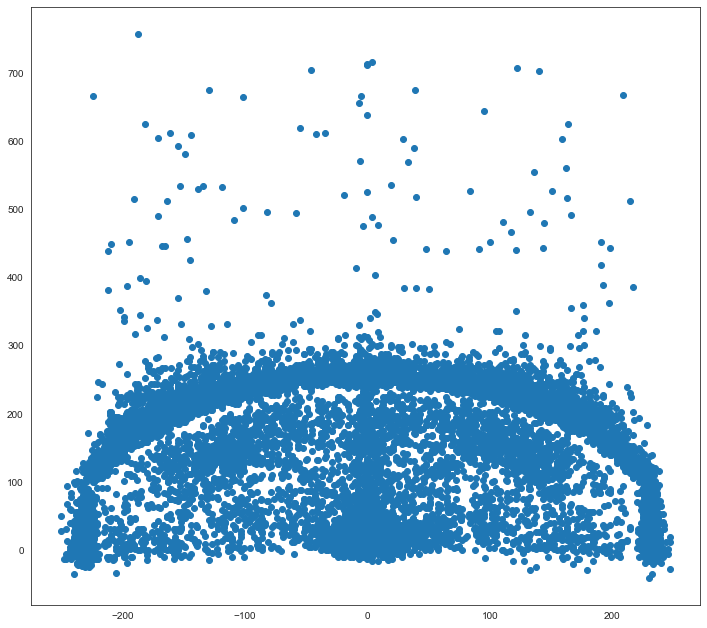

In [8]:
'''
creating a general scatter plot of all Curry's shots
'''
sns.set_style("white")
sns.set_color_codes()
plt.figure(figsize=(12,11))
plt.scatter(Curry.LOC_X, Curry.LOC_Y)
plt.show()

These were created courtesy of Savvas's visualizations http://savvastjortjoglou.com/nba-shot-sharts.html

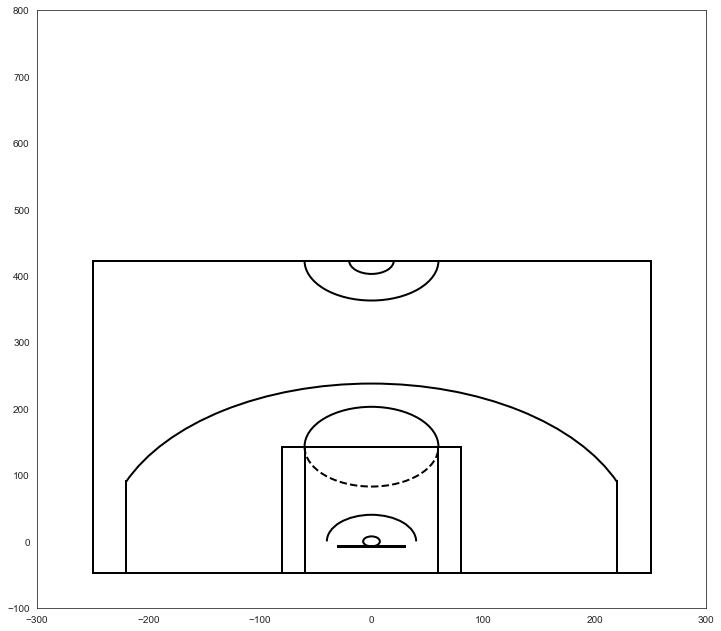

In [9]:
def draw_court(ax=None, color='black', lw=2, outer_lines=False):
    '''Creates a basketball court through matplotlib
    
    Args:
        ax (axis object, optional): If an axes object isn't provided to plot onto, just get current one
        color (string, optional): color of the basketball court
        lw (int, optional): width of each line for the basketball court
        outer_lines (bool, optional): whether the perimeter of the court should be drawn
    '''
    if ax is None:
        ax = plt.gca()

    # Create the various parts of an NBA basketball court

    # Create the basketball hoop
    # Diameter of a hoop is 18" so it has a radius of 9", which is a value
    # 7.5 in our coordinate system
    hoop = Circle((0, 0), radius=7.5, linewidth=lw, color=color, fill=False)

    # Create backboard
    backboard = Rectangle((-30, -7.5), 60, -1, linewidth=lw, color=color)

    # The paint
    # Create the outer box 0f the paint, width=16ft, height=19ft
    outer_box = Rectangle((-80, -47.5), 160, 190, linewidth=lw, color=color,
                          fill=False)
    # Create the inner box of the paint, widt=12ft, height=19ft
    inner_box = Rectangle((-60, -47.5), 120, 190, linewidth=lw, color=color,
                          fill=False)

    # Create free throw top arc
    top_free_throw = Arc((0, 142.5), 120, 120, theta1=0, theta2=180,
                         linewidth=lw, color=color, fill=False)
    # Create free throw bottom arc
    bottom_free_throw = Arc((0, 142.5), 120, 120, theta1=180, theta2=0,
                            linewidth=lw, color=color, linestyle='dashed')
    # Restricted Zone, it is an arc with 4ft radius from center of the hoop
    restricted = Arc((0, 0), 80, 80, theta1=0, theta2=180, linewidth=lw,
                     color=color)

    # Three point line
    # Create the side 3pt lines, they are 14ft long before they begin to arc
    corner_three_a = Rectangle((-220, -47.5), 0, 140, linewidth=lw,
                               color=color)
    corner_three_b = Rectangle((220, -47.5), 0, 140, linewidth=lw, color=color)
    # 3pt arc - center of arc will be the hoop, arc is 23'9" away from hoop
    # I just played around with the theta values until they lined up with the 
    # threes
    three_arc = Arc((0, 0), 475, 475, theta1=22, theta2=158, linewidth=lw,
                    color=color)

    # Center Court
    center_outer_arc = Arc((0, 422.5), 120, 120, theta1=180, theta2=0,
                           linewidth=lw, color=color)
    center_inner_arc = Arc((0, 422.5), 40, 40, theta1=180, theta2=0,
                           linewidth=lw, color=color)

    # List of the court elements to be plotted onto the axes
    court_elements = [hoop, backboard, outer_box, inner_box, top_free_throw,
                      bottom_free_throw, restricted, corner_three_a,
                      corner_three_b, three_arc, center_outer_arc,
                      center_inner_arc]

    if outer_lines:
        # Draw the half court line, baseline and side out bound lines
        outer_lines = Rectangle((-250, -47.5), 500, 470, linewidth=lw,
                                color=color, fill=False)
        court_elements.append(outer_lines)

    # Add the court elements onto the axes
    for element in court_elements:
        ax.add_patch(element)

    return ax

plt.figure(figsize=(12,11))
draw_court(outer_lines=True)
plt.xlim(-300,300)
plt.ylim(-100,800)
plt.show()

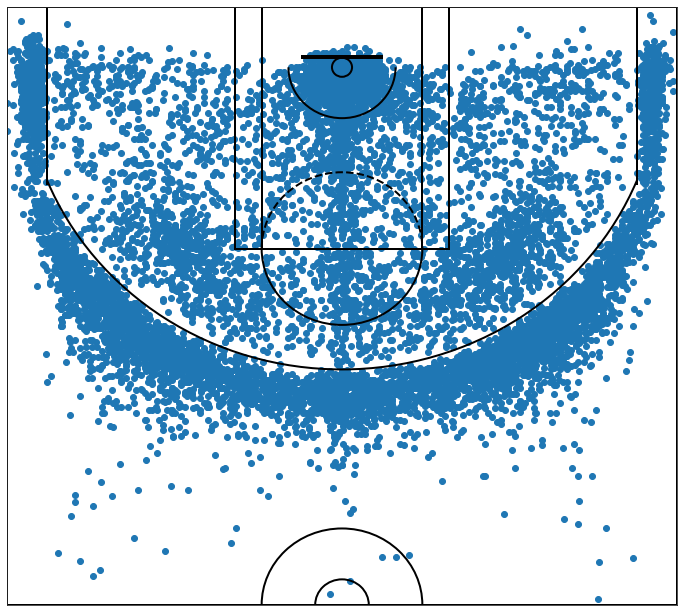

In [10]:
'''
plotting Curry's shots from inside half court
'''
plt.figure(figsize=(12,11))
plt.scatter(Curry.LOC_X, Curry.LOC_Y)
draw_court(outer_lines = True)
# Adjust plot limits to just fit in half court
plt.xlim(-250,250)
# Descending values along th y axis from bottom to top
# in order to place the hoop by the top of plot
plt.ylim(422.5, -47.5)
# get rid of axis tick labels
plt.tick_params(labelbottom=False, labelleft=False)
plt.show()

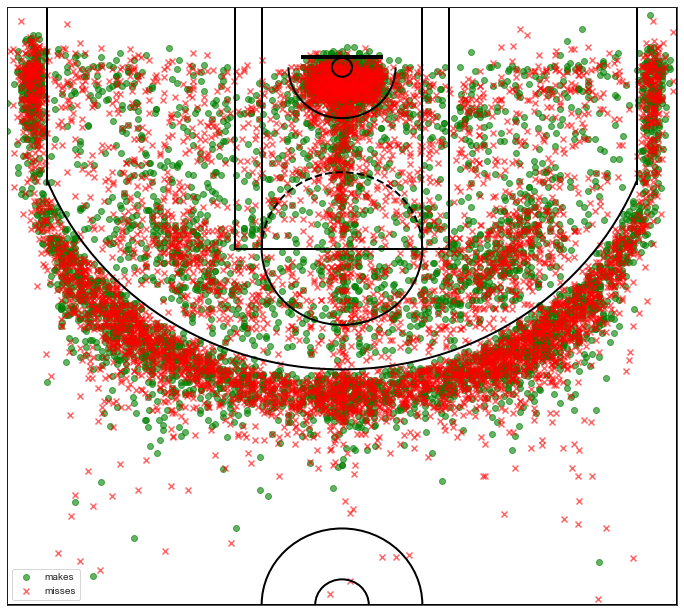

In [11]:
'''
viewing Curry's made and missed shots over the course of his career
'''
plt.figure(figsize=(12,11))
#providing 
plt.scatter(Curry.loc[Curry["SHOT_MADE_FLAG"] == 1,"LOC_X"], 
            Curry.loc[Curry["SHOT_MADE_FLAG"] == 1,"LOC_Y"], c = 'green', label = 'makes', alpha = 0.6)
plt.scatter(Curry.loc[Curry["SHOT_MADE_FLAG"] == 0,"LOC_X"], 
            Curry.loc[Curry["SHOT_MADE_FLAG"] == 0,"LOC_Y"], c = 'red', marker = 'x', label = 'misses', alpha = 0.6)
draw_court(outer_lines = True)
# Adjust plot limits to just fit in half court
plt.xlim(-250,250)
# Descending values along th y axis from bottom to top
# in order to place the hoop by the top of plot
plt.ylim(422.5, -47.5)
# get rid of axis tick labels
plt.tick_params(labelbottom=False, labelleft=False)
#placing the legend in the lower left corner
plt.legend(loc='lower left')
plt.show()

In [12]:
def heatmap_Curry_shots(shot_indicator):
    '''Viewing where most of Curry's shots are made or missed
    
    Args:
        shot_indicator (int): a 1 if wanting to see Curry's makes, 0 if wanting to see Curry's misses
        
    Returns:
        heatmap with Curry's made or missed shots
    '''
    
    # n_levels sets the number of contour lines for the main kde plot
    joint_shot_chart = sns.jointplot(Curry.loc[Curry["SHOT_MADE_FLAG"] == shot_indicator,"LOC_X"], 
                                     Curry.loc[Curry["SHOT_MADE_FLAG"] == shot_indicator,"LOC_Y"], stat_func=None,
                                     kind='kde', cmap = 'hsv',space=0, n_levels=50)

    joint_shot_chart.fig.set_size_inches(12,11)

    # A joint plot has 3 Axes, the first one called ax_joint 
    # is the one we want to draw our court onto and adjust some other settings
    ax = joint_shot_chart.ax_joint
    draw_court(ax)

    # Adjust the axis limits and orientation of the plot in order
    # to plot half court, with the hoop by the top of the plot
    ax.set_xlim(-250,250)
    ax.set_ylim(422.5, -47.5)

    # Get rid of axis labels and tick marks
    ax.set_xlabel('')
    ax.set_ylabel('')

    ax.tick_params(labelbottom='off', labelleft='off')

    # Add a title
    if shot_indicator == 1:
        plt.title('Steph Curry Made Shots (Career)')
    else:
        plt.title('Steph Curry Missed Shots (Career)')

    plt.show()

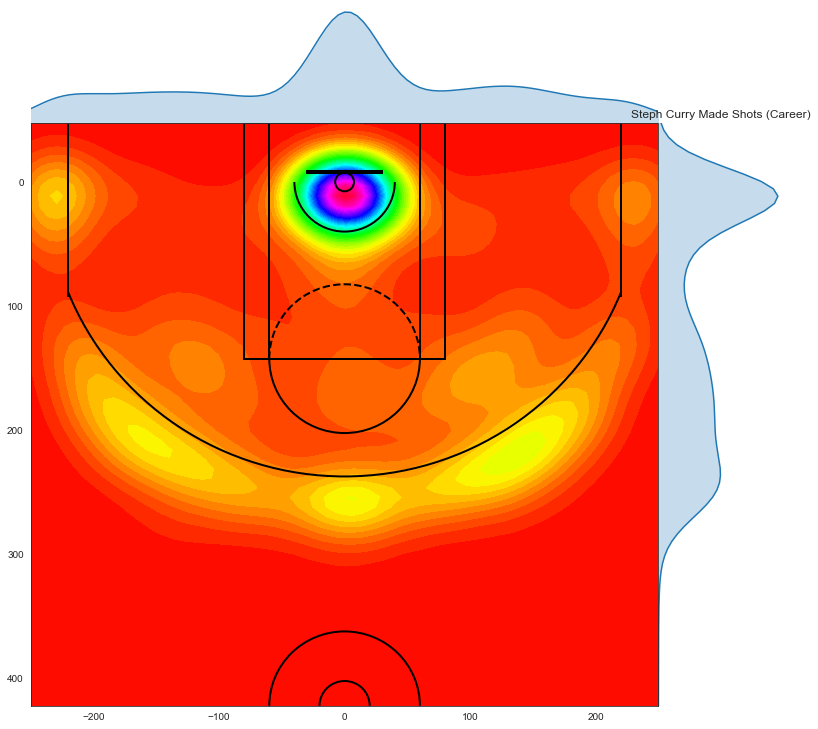

In [13]:
heatmap_Curry_shots(1)

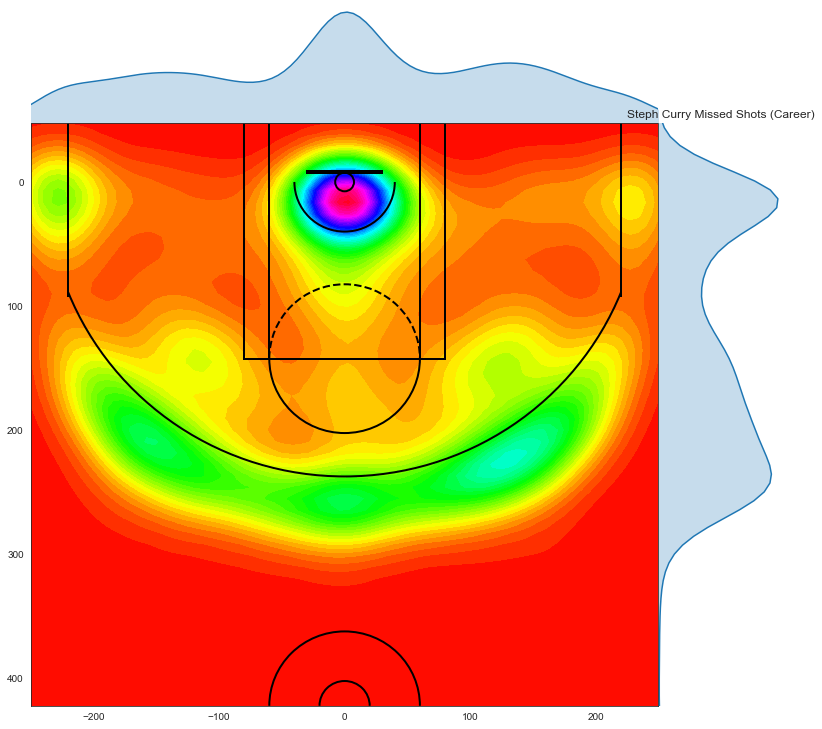

In [14]:
heatmap_Curry_shots(0)

## Dropping Unneccessary Columns

In [15]:
'''
checking how many different values there are in columns that should only have one value for Steph Curry
'''
def only_one_unique(column_list):
    '''print out the unique values in list of columns
    
    Args:
        column_list(list): a list of columns to examine
    '''
    for column in column_list:
        print(Curry[column].unique())
        
columns = ['GRID_TYPE','TEAM_NAME','TEAM_ID','PLAYER_ID','PLAYER_NAME','EVENT_TYPE','SHOT_ATTEMPTED_FLAG']

only_one_unique(columns)

['Shot Chart Detail']
['Golden State Warriors']
[1610612744]
[201939]
['Stephen Curry']
['Missed Shot' 'Made Shot']
[1]


In [16]:
'''
don't need these columns b/c they are all constants throughout the dataset
'''
drop_columns_Curry = Curry.drop(['GRID_TYPE','TEAM_NAME','TEAM_ID','PLAYER_ID','PLAYER_NAME','SHOT_ATTEMPTED_FLAG'],axis = 1)
print(Curry.shape)
print(drop_columns_Curry.shape)

(11928, 24)
(11928, 18)


In [17]:
with pd.option_context('display.max_columns', None):
    display(drop_columns_Curry.head(7))

GAME_ID  GAME_EVENT_ID  PERIOD  MINUTES_REMAINING  SECONDS_REMAINING  \
0  0020900015              4       1                 11                 25   
1  0020900015             17       1                  9                 31   
2  0020900015             53       1                  6                  2   
3  0020900015            141       2                  9                 49   
4  0020900015            249       2                  2                 19   
5  0020900015            277       2                  0                 34   
6  0020900015            413       4                 10                 26   

    EVENT_TYPE          ACTION_TYPE       SHOT_TYPE        SHOT_ZONE_BASIC  \
0  Missed Shot            Jump Shot  3PT Field Goal      Above the Break 3   
1    Made Shot  Step Back Jump shot  2PT Field Goal              Mid-Range   
2  Missed Shot            Jump Shot  2PT Field Goal  In The Paint (Non-RA)   
3  Missed Shot            Jump Shot  2PT Field Goal              Mid-Range   
4  Missed Shot            Jump Shot  2PT Field Goal              Mid-Range   
5  Missed Shot            Jump Shot  2PT Field Goal  In The Paint (Non-RA)   
6    Made Shot     Pullup Jump shot  2PT Field Goal              Mid-Range   

          SHOT_ZONE_AREA  SHOT_ZONE_RANGE  SHOT_DISTANCE  LOC_X  LOC_Y  \
0  Right Side Center(RC)          24+ ft.             26     99    249   
1   Left Side Center(LC)        16-24 ft.             18   -122    145   
2              Center(C)         8-16 ft.             14    -60    129   
3           Left Side(L)        16-24 ft.             19   -172     82   
4   Left Side Center(LC)        16-24 ft.             16    -68    148   
5              Center(C)  Less Than 8 ft.              4     39     15   
6   Left Side Center(LC)        16-24 ft.             16    -64    149   

   SHOT_MADE_FLAG GAME_DATE  HTM  VTM  
0               0  20091028  GSW  HOU  
1               1  20091028  GSW  HOU  
2               0  20091028  GSW  HOU  
3               0  20091028  GSW  HOU  
4               0  20091028  GSW  HOU  
5               0  20091028  GSW  HOU  
6               1  20091028  GSW  HOU

In [18]:
'''
finding how many shots Curry has made and missed in his career
'''
grouped = drop_columns_Curry.groupby('EVENT_TYPE')
print(grouped['SHOT_MADE_FLAG'].size())

EVENT_TYPE
Made Shot      5680
Missed Shot    6248
Name: SHOT_MADE_FLAG, dtype: int64


In [19]:
'''
examining his percentage of makes and misses over the course of his career
'''
makes = sum(drop_columns_Curry['EVENT_TYPE'] == 'Made Shot') / drop_columns_Curry.shape[0]
misses = sum(drop_columns_Curry['EVENT_TYPE'] == 'Missed Shot') / drop_columns_Curry.shape[0]
print("Curry has made {:.3f}% and has missed {:.3f}% of his shots in his career".format(makes, misses))

Curry has made 0.476% and has missed 0.524% of his shots in his career


# Baseline: If I can build a model that produces better than 0.52 in accuracy, then my model is doing better than the baseline of guessing Curry has missed every shot in his career

## Feature Engineering

In [20]:
'''
examining the columns available after dropping the known unneccesary ones
'''
print(drop_columns_Curry.columns.tolist())

['GAME_ID', 'GAME_EVENT_ID', 'PERIOD', 'MINUTES_REMAINING', 'SECONDS_REMAINING', 'EVENT_TYPE', 'ACTION_TYPE', 'SHOT_TYPE', 'SHOT_ZONE_BASIC', 'SHOT_ZONE_AREA', 'SHOT_ZONE_RANGE', 'SHOT_DISTANCE', 'LOC_X', 'LOC_Y', 'SHOT_MADE_FLAG', 'GAME_DATE', 'HTM', 'VTM']


In [21]:
'''
examining the types of shots that NBA.com categorizes for Curry
'''
print(drop_columns_Curry['ACTION_TYPE'].unique())
print(len(drop_columns_Curry['ACTION_TYPE'].unique()))

['Jump Shot' 'Step Back Jump shot' 'Pullup Jump shot' 'Layup Shot'
 'Jump Bank Shot' 'Driving Layup Shot' 'Reverse Layup Shot'
 'Running Jump Shot' 'Floating Jump shot' 'Driving Finger Roll Layup Shot'
 'Running Hook Shot' 'Driving Reverse Layup Shot' 'Turnaround Jump Shot'
 'Fadeaway Jump Shot' 'Running Layup Shot' 'Running Bank shot'
 'Jump Hook Shot' 'Turnaround Bank shot' 'Driving Bank Hook Shot'
 'Running Reverse Layup Shot' 'Tip Shot' 'Fadeaway Bank shot' 'Hook Shot'
 'Pullup Bank shot' 'Finger Roll Layup Shot' 'Slam Dunk Shot'
 'Turnaround Fadeaway shot' 'Driving Dunk Shot' 'Driving Jump shot'
 'Hook Bank Shot' 'Driving Bank shot' 'Running Bank Hook Shot'
 'Putback Layup Shot' 'Dunk Shot' 'Driving Hook Shot'
 'Running Slam Dunk Shot' 'Running Finger Roll Layup Shot'
 'Driving Slam Dunk Shot' 'Turnaround Hook Shot'
 'Cutting Finger Roll Layup Shot' 'Cutting Layup Shot'
 'Running Pull-Up Jump Shot' 'Driving Floating Jump Shot'
 'Driving Floating Bank Jump Shot' 'Alley Oop Layup sh

In [22]:
def seconds(period, minutes, seconds):
    '''converting the PERIOD, MINUTES_REMAINING, SECONDS_REMAINING columns into a column that provides the number of 
    seconds into the game the shot occurred
    '''
    periods_completed = period - 1
    minutes_into_quarter = 12 - minutes - 1 #subtracting one makes it works with the seconds
    seconds_completed = 60 - seconds
    return (periods_completed * 720) + (minutes_into_quarter*60) + seconds_completed
  
drop_columns_Curry['Seconds Into Game'] = drop_columns_Curry.apply(lambda x: seconds(x['PERIOD'], 
                                            x['MINUTES_REMAINING'], x['SECONDS_REMAINING']), axis=1)
drop_columns_Curry.head(12)

GAME_ID  GAME_EVENT_ID  PERIOD  MINUTES_REMAINING  SECONDS_REMAINING  \
0   0020900015              4       1                 11                 25   
1   0020900015             17       1                  9                 31   
2   0020900015             53       1                  6                  2   
3   0020900015            141       2                  9                 49   
4   0020900015            249       2                  2                 19   
5   0020900015            277       2                  0                 34   
6   0020900015            413       4                 10                 26   
7   0020900015            453       4                  6                 31   
8   0020900015            487       4                  2                 25   
9   0020900015            490       4                  1                 47   
10  0020900015            508       4                  0                 29   
11  0020900015            520       4                  0                  0   

     EVENT_TYPE          ACTION_TYPE       SHOT_TYPE        SHOT_ZONE_BASIC  \
0   Missed Shot            Jump Shot  3PT Field Goal      Above the Break 3   
1     Made Shot  Step Back Jump shot  2PT Field Goal              Mid-Range   
2   Missed Shot            Jump Shot  2PT Field Goal  In The Paint (Non-RA)   
3   Missed Shot            Jump Shot  2PT Field Goal              Mid-Range   
4   Missed Shot            Jump Shot  2PT Field Goal              Mid-Range   
5   Missed Shot            Jump Shot  2PT Field Goal  In The Paint (Non-RA)   
6     Made Shot     Pullup Jump shot  2PT Field Goal              Mid-Range   
7     Made Shot     Pullup Jump shot  2PT Field Goal              Mid-Range   
8     Made Shot     Pullup Jump shot  2PT Field Goal              Mid-Range   
9     Made Shot     Pullup Jump shot  2PT Field Goal              Mid-Range   
10    Made Shot           Layup Shot  2PT Field Goal        Restricted Area   
11    Made Shot           Layup Shot  2PT Field Goal        Restricted Area   

           SHOT_ZONE_AREA  SHOT_ZONE_RANGE  SHOT_DISTANCE  LOC_X  LOC_Y  \
0   Right Side Center(RC)          24+ ft.             26     99    249   
1    Left Side Center(LC)        16-24 ft.             18   -122    145   
2               Center(C)         8-16 ft.             14    -60    129   
3            Left Side(L)        16-24 ft.             19   -172     82   
4    Left Side Center(LC)        16-24 ft.             16    -68    148   
5               Center(C)  Less Than 8 ft.              4     39     15   
6    Left Side Center(LC)        16-24 ft.             16    -64    149   
7   Right Side Center(RC)        16-24 ft.             17    118    123   
8   Right Side Center(RC)        16-24 ft.             20    121    162   
9    Left Side Center(LC)        16-24 ft.             18   -125    134   
10              Center(C)  Less Than 8 ft.              0     -7      1   
11              Center(C)  Less Than 8 ft.              1     -5     15   

    SHOT_MADE_FLAG GAME_DATE  HTM  VTM  Seconds Into Game  
0                0  20091028  GSW  HOU                 35  
1                1  20091028  GSW  HOU                149  
2                0  20091028  GSW  HOU                358  
3                0  20091028  GSW  HOU                851  
4                0  20091028  GSW  HOU               1301  
5                0  20091028  GSW  HOU               1406  
6                1  20091028  GSW  HOU               2254  
7                1  20091028  GSW  HOU               2489  
8                1  20091028  GSW  HOU               2735  
9                1  20091028  GSW  HOU               2773  
10               1  20091028  GSW  HOU               2851  
11               1  20091028  GSW  HOU               2880

In [23]:
'''
examining the 'Season' column
'''
drop_columns_Curry['Season'] = drop_columns_Curry['GAME_DATE']\
                                                    .map(lambda x: dt.datetime.strptime(x,"%Y%m%d").strftime("%Y"))
print(drop_columns_Curry['Season'].describe())
print(drop_columns_Curry['Season'].unique())

count     11928
unique       12
top        2016
freq       1574
Name: Season, dtype: object
['2009' '2010' '2011' '2012' '2013' '2014' '2015' '2016' '2017' '2018'
 '2019' '2020']


In [24]:
'''
examining how many shots Curry had in each season, starting with the most in 2016

'''
drop_columns_Curry['Season'].value_counts()

2016    1574
2015    1432
2013    1425
2014    1342
2017    1298
2010    1192
2018     967
2019     880
2012     759
2011     729
2009     314
2020      16
Name: Season, dtype: int64

In [25]:
'''
creating a new column that combines data from two separate columns on the location of the shot
'''
drop_columns_Curry['Shot Zone'] = drop_columns_Curry['SHOT_ZONE_BASIC'] + ' on ' + drop_columns_Curry['SHOT_ZONE_AREA']
drop_columns_Curry[['SHOT_ZONE_BASIC','SHOT_ZONE_AREA','Shot Zone']]

SHOT_ZONE_BASIC         SHOT_ZONE_AREA  \
0          Above the Break 3  Right Side Center(RC)   
1                  Mid-Range   Left Side Center(LC)   
2      In The Paint (Non-RA)              Center(C)   
3                  Mid-Range           Left Side(L)   
4                  Mid-Range   Left Side Center(LC)   
...                      ...                    ...   
11923      Above the Break 3  Right Side Center(RC)   
11924      Above the Break 3              Center(C)   
11925        Restricted Area              Center(C)   
11926      Above the Break 3  Right Side Center(RC)   
11927      Above the Break 3   Left Side Center(LC)   

                                        Shot Zone  
0      Above the Break 3 on Right Side Center(RC)  
1               Mid-Range on Left Side Center(LC)  
2              In The Paint (Non-RA) on Center(C)  
3                       Mid-Range on Left Side(L)  
4               Mid-Range on Left Side Center(LC)  
...                                           ...  
11923  Above the Break 3 on Right Side Center(RC)  
11924              Above the Break 3 on Center(C)  
11925                Restricted Area on Center(C)  
11926  Above the Break 3 on Right Side Center(RC)  
11927   Above the Break 3 on Left Side Center(LC)  

[11928 rows x 3 columns]

In [26]:
'''
creating a new column that says if the shot is from a home game or away game
'''
drop_columns_Curry['Home Game'] = drop_columns_Curry['HTM'].map(lambda x: 1 if x == 'GSW' else 0)
drop_columns_Curry.head(18)

GAME_ID  GAME_EVENT_ID  PERIOD  MINUTES_REMAINING  SECONDS_REMAINING  \
0   0020900015              4       1                 11                 25   
1   0020900015             17       1                  9                 31   
2   0020900015             53       1                  6                  2   
3   0020900015            141       2                  9                 49   
4   0020900015            249       2                  2                 19   
5   0020900015            277       2                  0                 34   
6   0020900015            413       4                 10                 26   
7   0020900015            453       4                  6                 31   
8   0020900015            487       4                  2                 25   
9   0020900015            490       4                  1                 47   
10  0020900015            508       4                  0                 29   
11  0020900015            520       4                  0                  0   
12  0020900030              9       1                 10                 39   
13  0020900030             18       1                  9                 27   
14  0020900030            258       2                  1                 28   
15  0020900030            264       2                  1                  0   
16  0020900030            313       3                  8                 35   
17  0020900030            374       3                  2                 57   

     EVENT_TYPE          ACTION_TYPE       SHOT_TYPE        SHOT_ZONE_BASIC  \
0   Missed Shot            Jump Shot  3PT Field Goal      Above the Break 3   
1     Made Shot  Step Back Jump shot  2PT Field Goal              Mid-Range   
2   Missed Shot            Jump Shot  2PT Field Goal  In The Paint (Non-RA)   
3   Missed Shot            Jump Shot  2PT Field Goal              Mid-Range   
4   Missed Shot            Jump Shot  2PT Field Goal              Mid-Range   
5   Missed Shot            Jump Shot  2PT Field Goal  In The Paint (Non-RA)   
6     Made Shot     Pullup Jump shot  2PT Field Goal              Mid-Range   
7     Made Shot     Pullup Jump shot  2PT Field Goal              Mid-Range   
8     Made Shot     Pullup Jump shot  2PT Field Goal              Mid-Range   
9     Made Shot     Pullup Jump shot  2PT Field Goal              Mid-Range   
10    Made Shot           Layup Shot  2PT Field Goal        Restricted Area   
11    Made Shot           Layup Shot  2PT Field Goal        Restricted Area   
12  Missed Shot            Jump Shot  3PT Field Goal      Above the Break 3   
13    Made Shot            Jump Shot  2PT Field Goal              Mid-Range   
14    Made Shot            Jump Shot  2PT Field Goal              Mid-Range   
15    Made Shot            Jump Shot  3PT Field Goal      Above the Break 3   
16  Missed Shot            Jump Shot  2PT Field Goal              Mid-Range   
17  Missed Shot           Layup Shot  2PT Field Goal        Restricted Area   

           SHOT_ZONE_AREA  ... LOC_X  LOC_Y  SHOT_MADE_FLAG  GAME_DATE  HTM  \
0   Right Side Center(RC)  ...    99    249               0   20091028  GSW   
1    Left Side Center(LC)  ...  -122    145               1   20091028  GSW   
2               Center(C)  ...   -60    129               0   20091028  GSW   
3            Left Side(L)  ...  -172     82               0   20091028  GSW   
4    Left Side Center(LC)  ...   -68    148               0   20091028  GSW   
5               Center(C)  ...    39     15               0   20091028  GSW   
6    Left Side Center(LC)  ...   -64    149               1   20091028  GSW   
7   Right Side Center(RC)  ...   118    123               1   20091028  GSW   
8   Right Side Center(RC)  ...   121    162               1   20091028  GSW   
9    Left Side Center(LC)  ...  -125    134               1   20091028  GSW   
10              Center(C)  ...    -7      1               1   20091028  GSW   
11              Center(C)  ...    -5     15            

In [27]:
'''
creating a new column that provides Curry's opponent
'''
def opponent(home, away):
    if home == 'GSW':
        return away
    return home
  
drop_columns_Curry['Opponent'] = drop_columns_Curry.apply(lambda x: opponent(x['HTM'], x['VTM']), axis=1)
drop_columns_Curry[['HTM','VTM','Opponent']]

HTM  VTM Opponent
0      GSW  HOU      HOU
1      GSW  HOU      HOU
2      GSW  HOU      HOU
3      GSW  HOU      HOU
4      GSW  HOU      HOU
...    ...  ...      ...
11923  GSW  TOR      TOR
11924  GSW  TOR      TOR
11925  GSW  TOR      TOR
11926  GSW  TOR      TOR
11927  GSW  TOR      TOR

[11928 rows x 3 columns]

In [28]:
'''
creating a new column based on whether or not the shot was worth 2 points or 3 points
'''
drop_columns_Curry['2PT FG'] = drop_columns_Curry['SHOT_TYPE'].map(lambda x: 1 if x == '2PT Field Goal' else 0)
drop_columns_Curry[['SHOT_TYPE','2PT FG']].head()

SHOT_TYPE  2PT FG
0  3PT Field Goal       0
1  2PT Field Goal       1
2  2PT Field Goal       1
3  2PT Field Goal       1
4  2PT Field Goal       1

In [29]:
with pd.option_context('display.max_columns', None):
    display(drop_columns_Curry.head())

GAME_ID  GAME_EVENT_ID  PERIOD  MINUTES_REMAINING  SECONDS_REMAINING  \
0  0020900015              4       1                 11                 25   
1  0020900015             17       1                  9                 31   
2  0020900015             53       1                  6                  2   
3  0020900015            141       2                  9                 49   
4  0020900015            249       2                  2                 19   

    EVENT_TYPE          ACTION_TYPE       SHOT_TYPE        SHOT_ZONE_BASIC  \
0  Missed Shot            Jump Shot  3PT Field Goal      Above the Break 3   
1    Made Shot  Step Back Jump shot  2PT Field Goal              Mid-Range   
2  Missed Shot            Jump Shot  2PT Field Goal  In The Paint (Non-RA)   
3  Missed Shot            Jump Shot  2PT Field Goal              Mid-Range   
4  Missed Shot            Jump Shot  2PT Field Goal              Mid-Range   

          SHOT_ZONE_AREA SHOT_ZONE_RANGE  SHOT_DISTANCE  LOC_X  LOC_Y  \
0  Right Side Center(RC)         24+ ft.             26     99    249   
1   Left Side Center(LC)       16-24 ft.             18   -122    145   
2              Center(C)        8-16 ft.             14    -60    129   
3           Left Side(L)       16-24 ft.             19   -172     82   
4   Left Side Center(LC)       16-24 ft.             16    -68    148   

   SHOT_MADE_FLAG GAME_DATE  HTM  VTM  Seconds Into Game Season  \
0               0  20091028  GSW  HOU                 35   2009   
1               1  20091028  GSW  HOU                149   2009   
2               0  20091028  GSW  HOU                358   2009   
3               0  20091028  GSW  HOU                851   2009   
4               0  20091028  GSW  HOU               1301   2009   

                                    Shot Zone  Home Game Opponent  2PT FG  
0  Above the Break 3 on Right Side Center(RC)          1      HOU       0  
1           Mid-Range on Left Side Center(LC)          1      HOU       1  
2          In The Paint (Non-RA) on Center(C)          1      HOU       1  
3                   Mid-Range on Left Side(L)          1      HOU       1  
4           Mid-Range on Left Side Center(LC)          1      HOU       1

In [30]:
drop_columns_Curry.shape

(11928, 24)

### Columns that will be used in the data analysis

In [31]:
drop_columns_Curry.columns.tolist()

['GAME_ID',
 'GAME_EVENT_ID',
 'PERIOD',
 'MINUTES_REMAINING',
 'SECONDS_REMAINING',
 'EVENT_TYPE',
 'ACTION_TYPE',
 'SHOT_TYPE',
 'SHOT_ZONE_BASIC',
 'SHOT_ZONE_AREA',
 'SHOT_ZONE_RANGE',
 'SHOT_DISTANCE',
 'LOC_X',
 'LOC_Y',
 'SHOT_MADE_FLAG',
 'GAME_DATE',
 'HTM',
 'VTM',
 'Seconds Into Game',
 'Season',
 'Shot Zone',
 'Home Game',
 'Opponent',
 '2PT FG']

In [32]:
'''
Why I don't need specific columns:
    don't need EVENT_TYPE because SHOT_MADE_FLAG is the binary version
    Seconds Into Game condenses period/minutes/seconds
    SHOT_TYPE is now 2PT FG
    SHOT_ZONEs are now condensed to Shot Zone and Shot_Distance
    GameDate, HTM, VTM have been parsed
'''
x_columns_Curry = drop_columns_Curry[[
 'ACTION_TYPE',
 'SHOT_DISTANCE',
 'LOC_X',
 'LOC_Y',
 'Home Game',
 'Seconds Into Game',
 'Season',
 'Shot Zone',
 'Opponent',
 '2PT FG']]
y_column_Curry = drop_columns_Curry['SHOT_MADE_FLAG']
print(x_columns_Curry.shape)
print(y_column_Curry.shape)

(11928, 10)
(11928,)


In [33]:
skew_of_numerical = x_columns_Curry[['SHOT_DISTANCE','LOC_X','LOC_Y','Seconds Into Game',]].skew()
skew_of_numerical

SHOT_DISTANCE       -0.206617
LOC_X               -0.081218
LOC_Y                0.454312
Seconds Into Game    0.083814
dtype: float64

# Splitting The Data 

In [34]:
X_train, X_test, Y_train, Y_test = train_test_split(x_columns_Curry, y_column_Curry, test_size = 0.25, shuffle = True,
                                                   random_state = 1)

In [35]:
def confirming_stratified_split(y):
    '''examining the number of makes and misses for the training and test sets to confirm they resemble the accuracy
    of Curry's makes and misses in his career (~52% missed, ~48% made)
    
    Args:
        y (Series): y values for the trianing set or the test set that's composed of 0 (misses) and 1 (makes)
    
    Returns:
        misses (float): about how much of the data set is composed of 0
        makes (float): about how much of the data set is composed of 1
    '''
    value_counts = y.value_counts()
    missed_shots_percent = value_counts[0] / value_counts.sum(axis = 0)
    made_shots_percent = value_counts[1] / value_counts.sum(axis = 0)
    misses = round(missed_shots_percent,3)
    makes = round(made_shots_percent,3)
    return misses, makes

In [36]:
'''
examining training set
'''
train_misses, train_makes = confirming_stratified_split(Y_train)
print("In the training set, Curry missed {} of his shots and made {} of his shots".format(train_misses,train_makes))
test_misses, test_makes = confirming_stratified_split(Y_test)
print("In the test set, Curry missed {} of his shots and made {} of his shots".format(test_misses,test_makes))

In the training set, Curry missed 0.526 of his shots and made 0.474 of his shots
In the test set, Curry missed 0.516 of his shots and made 0.484 of his shots


In [37]:
def unique_features(column_list, dataset, df_name):
    '''Checking the number of unique values in the four large category columns for train or test sets
    
    Args:
        column_list (list): the columns to examine
        dataset (DataFrame): either the independent variables for the train or test sets
        df_name (str): identifying whether it's the train or test set
    '''
    for i in column_list:
        print("The column {} has {} unique features in the {} set".format(i,len(dataset[i].unique()), df_name))
    print('\n')

columns = ['ACTION_TYPE','Season','Opponent','Shot Zone']
unique_features(columns, X_train, 'train')
unique_features(columns, X_test, 'test')

The column ACTION_TYPE has 50 unique features in the train set
The column Season has 12 unique features in the train set
The column Opponent has 31 unique features in the train set
The column Shot Zone has 16 unique features in the train set


The column ACTION_TYPE has 40 unique features in the test set
The column Season has 12 unique features in the test set
The column Opponent has 31 unique features in the test set
The column Shot Zone has 16 unique features in the test set




In [38]:
'''
creating instance of one-hot-encoder to see about how many columns the dataset for training will have
handle_unknow = 'ignore' means that the columns present in X_test are just not included
'''
enc = OneHotEncoder(handle_unknown='ignore')
fitting_Xtrain = enc.fit_transform(X_train[['ACTION_TYPE','Season','Opponent','Shot Zone']])
print(fitting_Xtrain.shape)
fitting_Xtest = enc.transform(X_test[['ACTION_TYPE','Season','Opponent','Shot Zone']])
print(fitting_Xtest.shape)

(8946, 109)
(2982, 109)


In [39]:
print(X_train.columns.tolist())
print(X_test.columns.tolist())

['ACTION_TYPE', 'SHOT_DISTANCE', 'LOC_X', 'LOC_Y', 'Home Game', 'Seconds Into Game', 'Season', 'Shot Zone', 'Opponent', '2PT FG']
['ACTION_TYPE', 'SHOT_DISTANCE', 'LOC_X', 'LOC_Y', 'Home Game', 'Seconds Into Game', 'Season', 'Shot Zone', 'Opponent', '2PT FG']


# Machine Learning Analysis

Using logistic, LDA, GaussianNB, GradientBoosting, AdaBoosting, SVC, Random Forest, Decision Trees, KNN

In [40]:
models = []
models.append(('LR', LogisticRegression())) 
models.append(('LDA', LinearDiscriminantAnalysis())) 
models.append(('KNN', KNeighborsClassifier())) 
models.append(('DT', DecisionTreeClassifier())) 
models.append(('NB', GaussianNB())) 
models.append(('SVM', SVC()))
models.append(('RF', RandomForestClassifier()))
models.append(('GBM',GradientBoostingClassifier()))
models.append(('ABM',AdaBoostClassifier()))
#print(models)

In [41]:
def column_transformer(include_standard = 'standardized'):
    '''creates the columns to use for the machine learning model by performing one-hot encoding on the non-binary 
    categorical variablese and possible standardization of numerical variables
    
    Args:
        include_standard (str, optional): whether or not the numerical variables should be standardized
        
    Returns:
        ColumnTransformer: the columns that are used for the ML model and passed to the pipeline
    
    '''
    ohe_vars = ['ACTION_TYPE','Season','Opponent','Shot Zone']
    passthrough_vars = None
    numerical_vars = None
    steps = None
    if include_standard == 'unstandardized':
        passthrough_vars = ['SHOT_DISTANCE', 'LOC_X', 'LOC_Y', 'Home Game', 'Seconds Into Game','2PT FG']
    elif include_standard == 'standardized':
        numerical_vars = ['SHOT_DISTANCE', 'LOC_X', 'LOC_Y','2PT FG']
        passthrough_vars = ['Home Game', 'Seconds Into Game']
    else:
        raise NameError('The argument name \'standardized\' or \'unstandardized\' not specified correctly.')
        
        
    if numerical_vars is None:
        steps = [('cat',OneHotEncoder(handle_unknown='ignore'),ohe_vars), ('pass','passthrough',passthrough_vars)]
    else:
        steps = [('cat',OneHotEncoder(handle_unknown='ignore'),ohe_vars), ('num',StandardScaler(),numerical_vars),
             ('pass','passthrough',passthrough_vars)]
    ct = ColumnTransformer(steps, sparse_threshold = 0)
    
    return ct

#### SHOULD SUPPRESS WARNINGS IN FINAL VERSION

In [42]:
def run_models(models, column_transformer, scoring = 'accuracy', pca_components = None, svd_components = None):
    '''Runs 4 different 5-fold cross validations for each model to find its performance
    
    Args:
        models (list of tuples): the first element of the tuple is the model name, and the second element is
            the sklearn model
        column_transform (ColumnTransformer): the result from the column_transformer function
        scoring(str, optional): the scoring metric to use
        pca_components (int, optional): number of components for principal component analysis
        svd_components (int, optional): number of components for singular value decomposition
        
    Returns:
        dictionary: the name of the model as well as the 20 different performance scores
    
    '''
    results= {}
    for name, model in models:
        # wrap the model in a pipeline
        pipeline = None
        if pca_components is not None:
            pca = PCA(n_components = pca_components)
            pipeline = Pipeline(steps=[('t',ct),('pca',pca),('m',model)])
        elif svd_components is not None:
            svd = TruncatedSVD(n_components=svd_components)
            pipeline = Pipeline(steps=[('t',ct),('svd',svd),('m',model)])
        else:
            pipeline = Pipeline(steps=[('t',ct),('m',model)])
        #this means 20 total splits are performed, and it's the same 20 splits for each model
        cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=4, random_state=1)
        #evaluate the model
        scores = cross_val_score(pipeline, X_train, Y_train, scoring=scoring, cv=cv, verbose = 1)
        # add the scores to the dictionary
        results[name] = scores
        
    return results

In [43]:
def print_and_plot_model_scores(model_results):
    '''prints the model name along with its mean score and standard deviation
    
    Args:
        model_results (dict): keys are the model names, values are the model scores
    
    Prints:
        model names as well as the mean model score and standard deviation
        a box plot that shows the distribution of scores for each model
        
    '''
    for model_name, model_score in model_results.items():
        print('{} has a mean of {} and a standard deviation of {}'.format(model_name, 
                                                    np.format_float_positional(np.mean(model_score), precision=3), 
                                                    np.format_float_positional(np.std(model_score), precision=3)))
    
    fig = plt.figure(figsize=(10,10))
    plt.boxplot(model_results.values(), labels=model_results.keys(), showmeans=True)
    plt.show()

### Unstandardized Variables Model Comparison

In [44]:
%%time
ct = column_transformer('unstandardized')
model_results = run_models(models,ct)

[Parallel(n_jobs=None)]: Done  20 out of  20 | elapsed:    1.8s finished
[Parallel(n_jobs=None)]: Done  20 out of  20 | elapsed:    3.5s finished
[Parallel(n_jobs=None)]: Done  20 out of  20 | elapsed:    3.5s finished
[Parallel(n_jobs=None)]: Done  20 out of  20 | elapsed:    2.5s finished
[Parallel(n_jobs=None)]: Done  20 out of  20 | elapsed:    1.0s finished
[Parallel(n_jobs=None)]: Done  20 out of  20 | elapsed:  2.8min finished
[Parallel(n_jobs=None)]: Done  20 out of  20 | elapsed:    3.2s finished
[Parallel(n_jobs=None)]: Done  20 out of  20 | elapsed:   38.9s finished


CPU times: user 4min 6s, sys: 3.82 s, total: 4min 10s
Wall time: 3min 54s


[Parallel(n_jobs=None)]: Done  20 out of  20 | elapsed:   11.9s finished


LR has a mean of 0.657 and a standard deviation of 0.011
LDA has a mean of 0.657 and a standard deviation of 0.011
KNN has a mean of 0.538 and a standard deviation of 0.009
DT has a mean of 0.574 and a standard deviation of 0.012
NB has a mean of 0.599 and a standard deviation of 0.008
SVM has a mean of 0.546 and a standard deviation of 0.008
RF has a mean of 0.619 and a standard deviation of 0.013
GBM has a mean of 0.657 and a standard deviation of 0.009
ABM has a mean of 0.657 and a standard deviation of 0.011


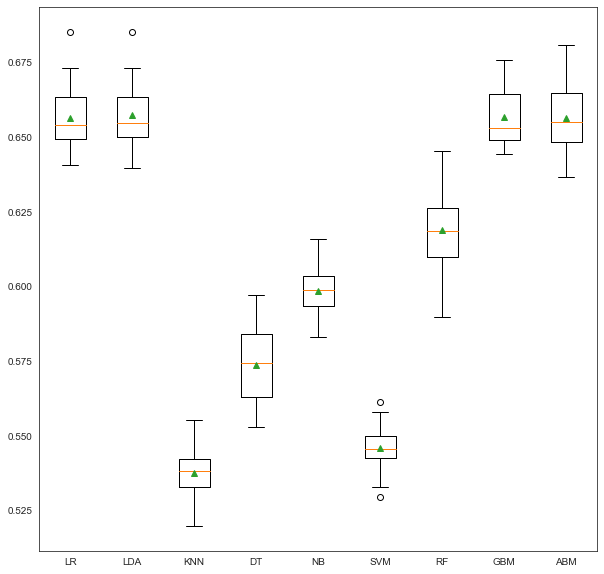

In [45]:
print_and_plot_model_scores(model_results)

### Standardized Variables Model Comparison

In [46]:
%%time
ct = column_transformer()
model_results = run_models(models,ct)

[Parallel(n_jobs=None)]: Done  20 out of  20 | elapsed:    1.6s finished
[Parallel(n_jobs=None)]: Done  20 out of  20 | elapsed:    3.4s finished
[Parallel(n_jobs=None)]: Done  20 out of  20 | elapsed:    3.1s finished
[Parallel(n_jobs=None)]: Done  20 out of  20 | elapsed:    2.5s finished
[Parallel(n_jobs=None)]: Done  20 out of  20 | elapsed:    1.1s finished
[Parallel(n_jobs=None)]: Done  20 out of  20 | elapsed:  2.7min finished
[Parallel(n_jobs=None)]: Done  20 out of  20 | elapsed:    3.3s finished
[Parallel(n_jobs=None)]: Done  20 out of  20 | elapsed:   39.5s finished


CPU times: user 3min 57s, sys: 2.72 s, total: 3min 59s
Wall time: 3min 45s


[Parallel(n_jobs=None)]: Done  20 out of  20 | elapsed:   12.2s finished


LR has a mean of 0.657 and a standard deviation of 0.011
LDA has a mean of 0.657 and a standard deviation of 0.011
KNN has a mean of 0.521 and a standard deviation of 0.008
DT has a mean of 0.573 and a standard deviation of 0.009
NB has a mean of 0.599 and a standard deviation of 0.008
SVM has a mean of 0.516 and a standard deviation of 0.010
RF has a mean of 0.617 and a standard deviation of 0.010
GBM has a mean of 0.657 and a standard deviation of 0.009
ABM has a mean of 0.657 and a standard deviation of 0.011


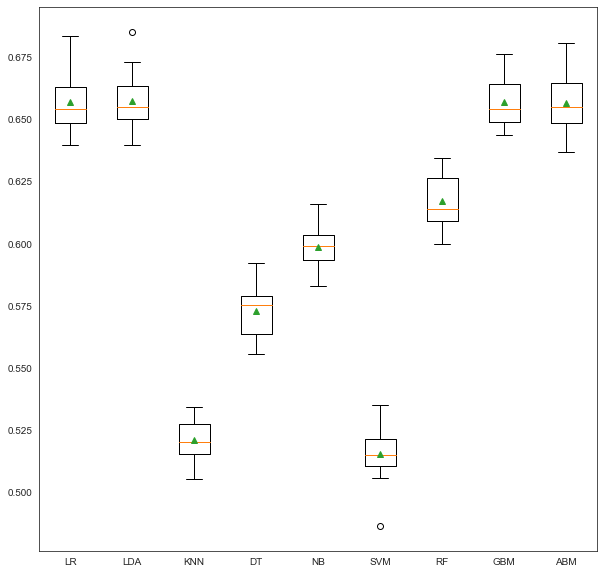

In [47]:
print_and_plot_model_scores(model_results)

This looks very similar to the unstandardized. This is most likely because there's only four variables that need to be standardized, and a large number of categorical variables. I'm going to try out dimensionality reduction with PCA (typically used for dense matrices) and SVD (typically used for sparse matrices).

### Determining number of components for PCA

In [48]:
ct = column_transformer()
pca_X_train = ct.fit_transform(X_train)
print(X_train.shape)
print(pca_X_train.shape)
pca = PCA(n_components = 115).fit(pca_X_train)
pca

(8946, 10)
(8946, 115)


PCA(copy=True, iterated_power='auto', n_components=115, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [49]:
'''
examining the explained variance for each component; the first component explains 99.9% of the variance
'''
pca_explain_var_ratio = pca.explained_variance_ratio_
pca_explain_var_ratio

array([9.99989211e-01, 3.75387756e-06, 1.52556541e-06, 6.24675363e-07,
       4.41708494e-07, 3.25999307e-07, 2.55033168e-07, 1.82604711e-07,
       1.68961173e-07, 1.66452578e-07, 1.63531200e-07, 1.55443181e-07,
       1.43976521e-07, 1.35720372e-07, 1.28238906e-07, 1.26578168e-07,
       1.18306402e-07, 1.08896359e-07, 9.30949895e-08, 8.77733183e-08,
       7.46469900e-08, 7.38074621e-08, 7.01566408e-08, 6.90990655e-08,
       6.75909457e-08, 6.57163459e-08, 6.49240068e-08, 6.45741133e-08,
       6.22722018e-08, 6.07050480e-08, 6.03931251e-08, 5.95678782e-08,
       5.84072489e-08, 5.81607367e-08, 5.70225112e-08, 5.48620869e-08,
       5.33957040e-08, 5.14448636e-08, 4.73870271e-08, 4.45100644e-08,
       4.36824056e-08, 4.08993100e-08, 3.80983661e-08, 3.77143635e-08,
       3.70730247e-08, 3.65270055e-08, 3.59317249e-08, 3.56434321e-08,
       3.46710603e-08, 3.35190408e-08, 3.25365031e-08, 3.13109998e-08,
       2.97807662e-08, 2.95129913e-08, 2.90334616e-08, 2.88810022e-08,
      

Text(0, 0.5, 'cumulative explained variance')

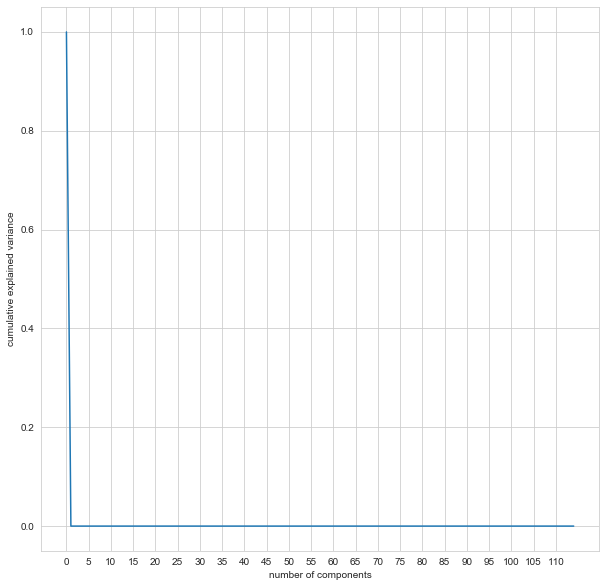

In [50]:
'''
plotting a graph to see the explained variance ratio for each of the components
'''
sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize=(10, 10))

ax.plot(pca.explained_variance_ratio_)
plt.xlabel('number of components')
ax.set_xticks(range(0,115,5))
plt.ylabel('cumulative explained variance')

### Examining when only including the main PCA component

In [51]:
%%time
ct = column_transformer()
model_results = run_models(models,ct,pca_components = 1)

[Parallel(n_jobs=None)]: Done  20 out of  20 | elapsed:    1.7s finished
[Parallel(n_jobs=None)]: Done  20 out of  20 | elapsed:    1.5s finished
[Parallel(n_jobs=None)]: Done  20 out of  20 | elapsed:    2.8s finished
[Parallel(n_jobs=None)]: Done  20 out of  20 | elapsed:    1.9s finished
[Parallel(n_jobs=None)]: Done  20 out of  20 | elapsed:    1.4s finished
[Parallel(n_jobs=None)]: Done  20 out of  20 | elapsed:   29.7s finished
[Parallel(n_jobs=None)]: Done  20 out of  20 | elapsed:    4.5s finished
[Parallel(n_jobs=None)]: Done  20 out of  20 | elapsed:    5.4s finished


CPU times: user 2min 20s, sys: 5.33 s, total: 2min 25s
Wall time: 54.3 s


[Parallel(n_jobs=None)]: Done  20 out of  20 | elapsed:    5.4s finished


LR has a mean of 0.526 and a standard deviation of 0.000
LDA has a mean of 0.526 and a standard deviation of 0.000
KNN has a mean of 0.504 and a standard deviation of 0.008
DT has a mean of 0.512 and a standard deviation of 0.012
NB has a mean of 0.526 and a standard deviation of 0.000
SVM has a mean of 0.508 and a standard deviation of 0.007
RF has a mean of 0.509 and a standard deviation of 0.009
GBM has a mean of 0.515 and a standard deviation of 0.008
ABM has a mean of 0.520 and a standard deviation of 0.009


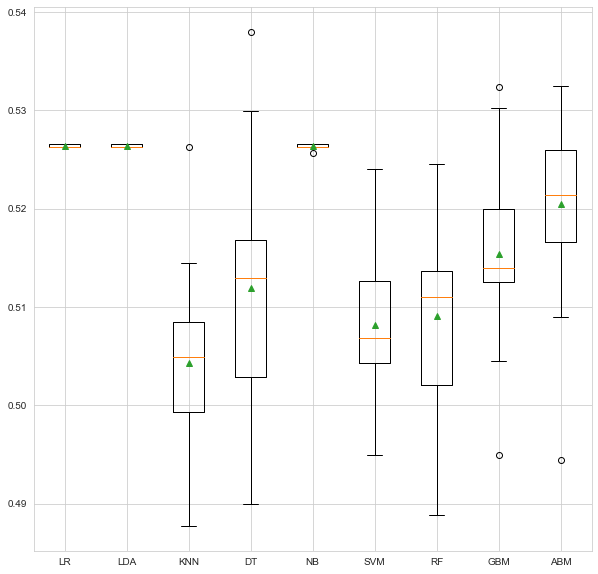

In [52]:
print_and_plot_model_scores(model_results)

In [53]:
%%time
ct = column_transformer()
model_results = run_models(models,ct,pca_components = 25)

[Parallel(n_jobs=None)]: Done  20 out of  20 | elapsed:    2.5s finished
[Parallel(n_jobs=None)]: Done  20 out of  20 | elapsed:    2.3s finished
[Parallel(n_jobs=None)]: Done  20 out of  20 | elapsed:    3.3s finished
[Parallel(n_jobs=None)]: Done  20 out of  20 | elapsed:    6.6s finished
[Parallel(n_jobs=None)]: Done  20 out of  20 | elapsed:    1.8s finished
[Parallel(n_jobs=None)]: Done  20 out of  20 | elapsed:   56.0s finished
[Parallel(n_jobs=None)]: Done  20 out of  20 | elapsed:    8.4s finished
[Parallel(n_jobs=None)]: Done  20 out of  20 | elapsed:   31.0s finished


CPU times: user 4min 8s, sys: 5.83 s, total: 4min 13s
Wall time: 2min 17s


[Parallel(n_jobs=None)]: Done  20 out of  20 | elapsed:   25.4s finished


LR has a mean of 0.644 and a standard deviation of 0.012
LDA has a mean of 0.645 and a standard deviation of 0.012
KNN has a mean of 0.521 and a standard deviation of 0.007
DT has a mean of 0.568 and a standard deviation of 0.010
NB has a mean of 0.629 and a standard deviation of 0.010
SVM has a mean of 0.524 and a standard deviation of 0.01
RF has a mean of 0.612 and a standard deviation of 0.01
GBM has a mean of 0.650 and a standard deviation of 0.010
ABM has a mean of 0.640 and a standard deviation of 0.008


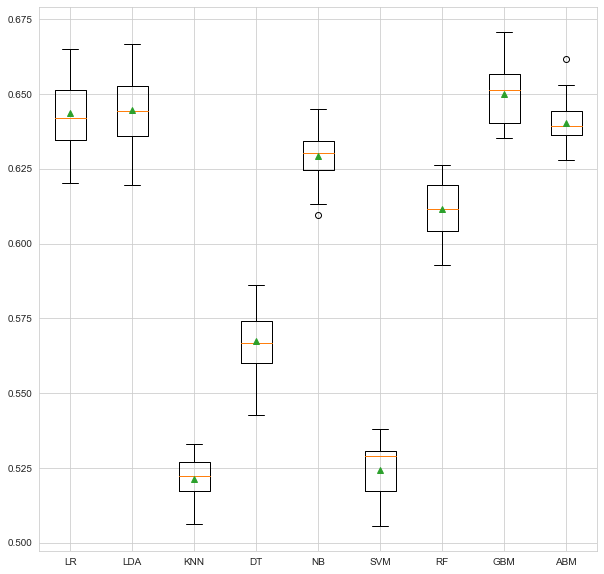

In [54]:
print_and_plot_model_scores(model_results)

It appears from initial analysis that PCA dimensionality reduction doesn't diminish the noise of the data; while it didn't improve most of the models, it did improve the Naive Bayes model

### Checking to see that the results are similar when using ROC performance metric

In [55]:
%%time
ct = column_transformer()
model_results = run_models(models,ct,scoring='roc_auc')

[Parallel(n_jobs=None)]: Done  20 out of  20 | elapsed:    1.7s finished
[Parallel(n_jobs=None)]: Done  20 out of  20 | elapsed:    3.4s finished
[Parallel(n_jobs=None)]: Done  20 out of  20 | elapsed:    2.1s finished
[Parallel(n_jobs=None)]: Done  20 out of  20 | elapsed:    2.5s finished
[Parallel(n_jobs=None)]: Done  20 out of  20 | elapsed:    1.1s finished
[Parallel(n_jobs=None)]: Done  20 out of  20 | elapsed:  2.6min finished
[Parallel(n_jobs=None)]: Done  20 out of  20 | elapsed:    3.4s finished
[Parallel(n_jobs=None)]: Done  20 out of  20 | elapsed:   39.5s finished


CPU times: user 3min 53s, sys: 2.51 s, total: 3min 56s
Wall time: 3min 41s


[Parallel(n_jobs=None)]: Done  20 out of  20 | elapsed:   12.2s finished


LR has a mean of 0.695 and a standard deviation of 0.014
LDA has a mean of 0.695 and a standard deviation of 0.014
KNN has a mean of 0.528 and a standard deviation of 0.009
DT has a mean of 0.573 and a standard deviation of 0.013
NB has a mean of 0.649 and a standard deviation of 0.013
SVM has a mean of 0.531 and a standard deviation of 0.011
RF has a mean of 0.658 and a standard deviation of 0.012
GBM has a mean of 0.709 and a standard deviation of 0.013
ABM has a mean of 0.697 and a standard deviation of 0.013


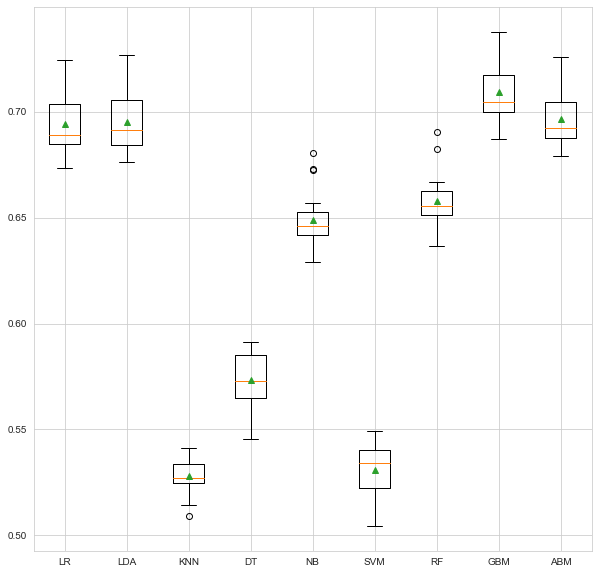

In [56]:
print_and_plot_model_scores(model_results)

Produces similar results with the best scores between logistic regression, LDA, AdaBoost, and Gradient Boosting

### Using SVD to compare model performances

In [57]:
ct = column_transformer()
svd_X_train = ct.fit_transform(X_train)
print(X_train.shape)
print(svd_X_train.shape)
#must be one less b/c there's supposed to be dimensionality reduction
svd = TruncatedSVD(n_components = svd_X_train.shape[1] -1).fit(svd_X_train)

(8946, 10)
(8946, 115)


In [58]:
tsv_explain_var_ratio = svd.explained_variance_ratio_
type(tsv_explain_var_ratio)
print(tsv_explain_var_ratio)
print(sum(tsv_explain_var_ratio))

[9.99988998e-01 3.75446433e-06 1.52803174e-06 6.24677085e-07
 4.30350168e-07 4.27289991e-07 2.94980281e-07 1.82707424e-07
 1.69011307e-07 1.66472725e-07 1.63531467e-07 1.55811306e-07
 1.46104243e-07 1.42954093e-07 1.33244545e-07 1.27919079e-07
 1.19334586e-07 1.08899208e-07 9.53078745e-08 8.87610982e-08
 7.75830363e-08 7.41091363e-08 7.36774287e-08 7.01548053e-08
 6.90952105e-08 6.73138251e-08 6.57067797e-08 6.47863832e-08
 6.45442624e-08 6.21817344e-08 6.07050449e-08 6.02474896e-08
 5.95676631e-08 5.84068710e-08 5.79897897e-08 5.70103091e-08
 5.48350466e-08 5.25766951e-08 4.84864574e-08 4.73475831e-08
 4.37833962e-08 4.20845756e-08 4.05128807e-08 3.79497126e-08
 3.71634413e-08 3.69778008e-08 3.60917870e-08 3.58623673e-08
 3.53630783e-08 3.46384776e-08 3.34424237e-08 3.25002002e-08
 3.12493489e-08 2.97552576e-08 2.90909754e-08 2.88815022e-08
 2.80912403e-08 2.74173132e-08 2.67860339e-08 2.54609318e-08
 1.77081402e-08 1.52855743e-08 1.47156546e-08 1.46511815e-08
 1.31023810e-08 1.198517

In [59]:
tsv_explain_var = svd.explained_variance_
tsv_explain_var

array([7.15488752e+05, 2.68630656e+00, 1.09330155e+00, 4.46954345e-01,
       3.07914092e-01, 3.05724546e-01, 2.11057395e-01, 1.30726545e-01,
       1.20927020e-01, 1.19110673e-01, 1.17006212e-01, 1.11482463e-01,
       1.04537093e-01, 1.02283171e-01, 9.53360223e-02, 9.15256695e-02,
       8.53834933e-02, 7.79170153e-02, 6.81924624e-02, 6.35082661e-02,
       5.55104005e-02, 5.30248368e-02, 5.27159515e-02, 5.01955263e-02,
       4.94373898e-02, 4.81628146e-02, 4.70129790e-02, 4.63544384e-02,
       4.61812018e-02, 4.44908210e-02, 4.34342547e-02, 4.31068754e-02,
       4.26204619e-02, 4.17899190e-02, 4.14914988e-02, 4.07906837e-02,
       3.92342907e-02, 3.76184478e-02, 3.46918966e-02, 3.38770358e-02,
       3.13268721e-02, 3.01113717e-02, 2.89868294e-02, 2.71528912e-02,
       2.65903168e-02, 2.64574916e-02, 2.58235517e-02, 2.56594027e-02,
       2.53021631e-02, 2.47837138e-02, 2.39279413e-02, 2.32537835e-02,
       2.23588036e-02, 2.12897864e-02, 2.08144947e-02, 2.06646173e-02,
      

Text(0, 0.5, 'cumulative explained variance')

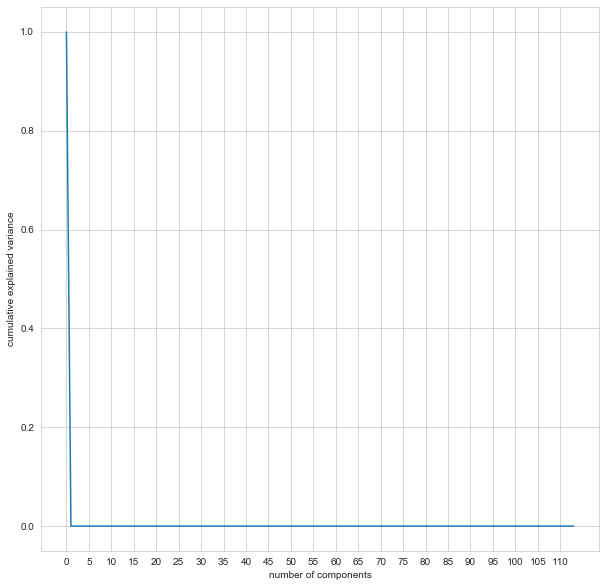

In [60]:
'''
plotting a graph to see the explained variance ratio for each of the components
'''
fig, ax = plt.subplots(figsize=(10, 10))

ax.plot(tsv_explain_var_ratio)
plt.xlabel('number of components')
ax.set_xticks(range(0,115,5))
plt.ylabel('cumulative explained variance')

In [61]:
%%time
ct = column_transformer()
model_results = run_models(models,ct,svd_components = 25)

[Parallel(n_jobs=None)]: Done  20 out of  20 | elapsed:    2.6s finished
[Parallel(n_jobs=None)]: Done  20 out of  20 | elapsed:    2.1s finished
[Parallel(n_jobs=None)]: Done  20 out of  20 | elapsed:    3.1s finished
[Parallel(n_jobs=None)]: Done  20 out of  20 | elapsed:    6.6s finished
[Parallel(n_jobs=None)]: Done  20 out of  20 | elapsed:    1.7s finished
[Parallel(n_jobs=None)]: Done  20 out of  20 | elapsed:   58.2s finished
[Parallel(n_jobs=None)]: Done  20 out of  20 | elapsed:    8.5s finished
[Parallel(n_jobs=None)]: Done  20 out of  20 | elapsed:   32.9s finished


CPU times: user 4min 9s, sys: 5.42 s, total: 4min 14s
Wall time: 2min 21s


[Parallel(n_jobs=None)]: Done  20 out of  20 | elapsed:   26.1s finished


LR has a mean of 0.641 and a standard deviation of 0.011
LDA has a mean of 0.641 and a standard deviation of 0.011
KNN has a mean of 0.522 and a standard deviation of 0.006
DT has a mean of 0.573 and a standard deviation of 0.009
NB has a mean of 0.631 and a standard deviation of 0.009
SVM has a mean of 0.525 and a standard deviation of 0.01
RF has a mean of 0.604 and a standard deviation of 0.011
GBM has a mean of 0.647 and a standard deviation of 0.009
ABM has a mean of 0.636 and a standard deviation of 0.011


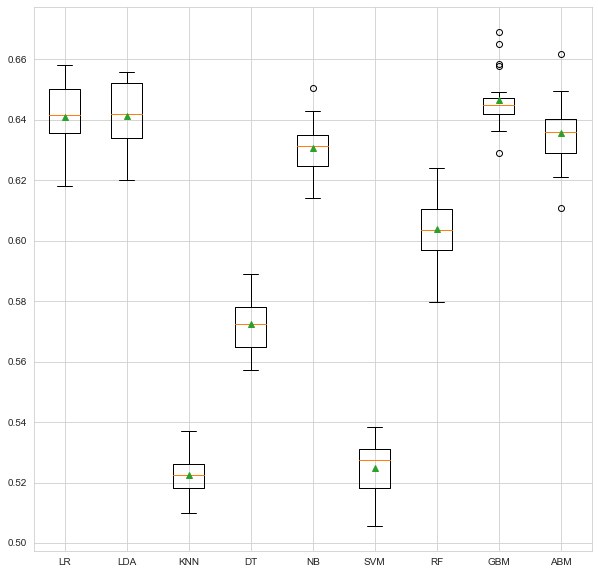

In [62]:
print_and_plot_model_scores(model_results)

In [63]:
%%time
ct = column_transformer()
model_results = run_models(models,ct,svd_components = 1)

[Parallel(n_jobs=None)]: Done  20 out of  20 | elapsed:    1.4s finished
[Parallel(n_jobs=None)]: Done  20 out of  20 | elapsed:    1.3s finished
[Parallel(n_jobs=None)]: Done  20 out of  20 | elapsed:    2.6s finished
[Parallel(n_jobs=None)]: Done  20 out of  20 | elapsed:    1.7s finished
[Parallel(n_jobs=None)]: Done  20 out of  20 | elapsed:    1.2s finished
[Parallel(n_jobs=None)]: Done  20 out of  20 | elapsed:   29.6s finished
[Parallel(n_jobs=None)]: Done  20 out of  20 | elapsed:    4.8s finished
[Parallel(n_jobs=None)]: Done  20 out of  20 | elapsed:    5.4s finished


CPU times: user 2min 17s, sys: 4.52 s, total: 2min 22s
Wall time: 53.9 s


[Parallel(n_jobs=None)]: Done  20 out of  20 | elapsed:    5.9s finished


LR has a mean of 0.526 and a standard deviation of 0.000
LDA has a mean of 0.526 and a standard deviation of 0.000
KNN has a mean of 0.506 and a standard deviation of 0.007
DT has a mean of 0.519 and a standard deviation of 0.009
NB has a mean of 0.526 and a standard deviation of 0.000
SVM has a mean of 0.508 and a standard deviation of 0.007
RF has a mean of 0.52 and a standard deviation of 0.009
GBM has a mean of 0.519 and a standard deviation of 0.01
ABM has a mean of 0.522 and a standard deviation of 0.007


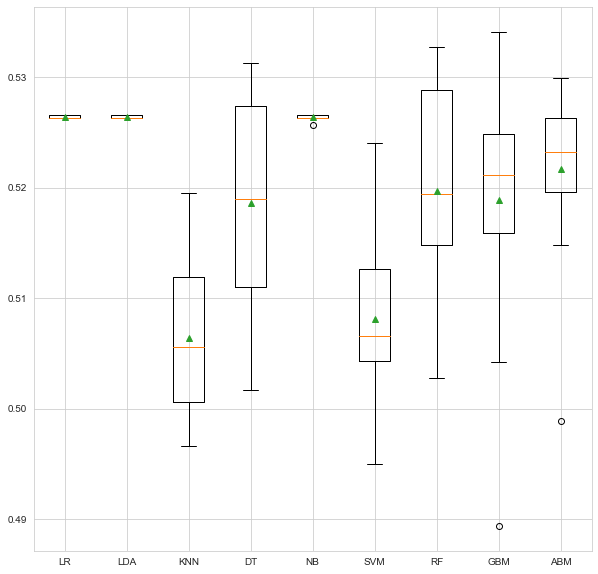

In [64]:
print_and_plot_model_scores(model_results)

In [65]:
%%time
ct = column_transformer()
model_results = run_models(models,ct,svd_components = 55)

[Parallel(n_jobs=None)]: Done  20 out of  20 | elapsed:    4.8s finished
[Parallel(n_jobs=None)]: Done  20 out of  20 | elapsed:    3.6s finished
[Parallel(n_jobs=None)]: Done  20 out of  20 | elapsed:    4.5s finished
[Parallel(n_jobs=None)]: Done  20 out of  20 | elapsed:   14.1s finished
[Parallel(n_jobs=None)]: Done  20 out of  20 | elapsed:    2.6s finished
[Parallel(n_jobs=None)]: Done  20 out of  20 | elapsed:  1.5min finished
[Parallel(n_jobs=None)]: Done  20 out of  20 | elapsed:   11.1s finished
[Parallel(n_jobs=None)]: Done  20 out of  20 | elapsed:  1.1min finished


CPU times: user 6min 19s, sys: 6.72 s, total: 6min 26s
Wall time: 4min 5s


[Parallel(n_jobs=None)]: Done  20 out of  20 | elapsed:   51.2s finished


LR has a mean of 0.654 and a standard deviation of 0.010
LDA has a mean of 0.655 and a standard deviation of 0.012
KNN has a mean of 0.521 and a standard deviation of 0.008
DT has a mean of 0.566 and a standard deviation of 0.013
NB has a mean of 0.613 and a standard deviation of 0.011
SVM has a mean of 0.522 and a standard deviation of 0.010
RF has a mean of 0.604 and a standard deviation of 0.009
GBM has a mean of 0.651 and a standard deviation of 0.01
ABM has a mean of 0.638 and a standard deviation of 0.01


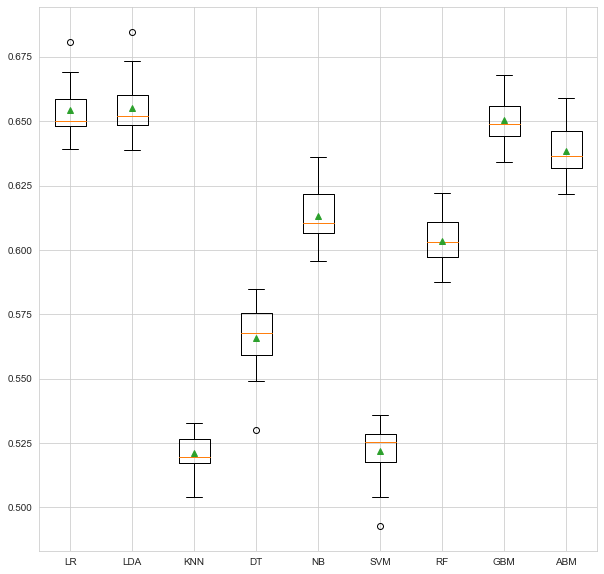

In [66]:
print_and_plot_model_scores(model_results)

It's surprising that 99.99% of the explained variance comes from a single component, but unfortunately using that does not produce better results for any of the algorithms. Having a larger number of components produces similar results to no dimensionality reduction, but still not quite as good

### KNN, SVM, and Decision Trees Showed No Signs of Providing a Good Model

### The best results appeared with the highest mean and lowest standard deviation when there is no dimensionality reduction with logistic regression, LDA, AdaBoost, and GBM. I've decided to work with the standardized numerical variables rather than the unstandardized variables as it produces fewer iterations for the Logistic Regression models

### RandomizedSearchCV for Hyperparameter Tuning...

have the same steps and column transformer, but have a different name and model for pipeline (check)

different hyperparameters for each model

can combine best hyperparameters, best score, and best DataFrame results

In [67]:
def pipeline_random_search(column_transformer, ml_name, ml_base_algorithm):
    '''Creates the pipeline for the machine learning algorithm being examined
    
    Args:
        column_transformer (Column_transformer): the columns that are used for the ML model and passed to the pipeline
        ml_name (str): the name of the machine learning algorithm
        ml_base_algorithm (sklearn object): the machine learning model with the base hyperparameters
    '''
    return Pipeline(steps=[('t',column_transformer),(ml_name, ml_base_algorithm)])

In [68]:
def random_search_results(pipeline, hyperparameters):
    '''Runs the Randomized Search
    
    Args:
        pipeline (Pipeline): the pipeline for the ML algorithm
        hyperparameters (dict): the hyperparameters being examined for the ML algorithm
        
    Returns:
        results (DataFrame): a DataFrame with information about the hyperparameters that produced the best
            test results
    
    '''
    #this means 10 total splits are performed, and it's the same 10 splits for each model
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=1) 
    random_search = RandomizedSearchCV(pipeline, hyperparameters, n_iter=75,
            scoring = 'accuracy',refit = 'accuracy',cv=cv, verbose=1, n_jobs=-1)
    
    # Fit randomized search
    best_random = random_search.fit(X_train, Y_train)
    
    # View best hyperparameters
    print('Best Parameters:', best_random.best_params_)
    print('Best score:', best_random.best_score_)
    
    results = pd.DataFrame(best_random.cv_results_)
    results.sort_values(by='rank_test_score',inplace= True)
    return results

In [69]:
#I want to try lbfgs, liblinear, and saga
l2_logreg = LogisticRegression(penalty = 'l2', max_iter = 400)
l2_logreg_pipeline = pipeline_random_search(column_transformer(), 'l2_logreg', l2_logreg)

In [70]:
# first access the parameter keys of the individual estimators
l2_logreg_pipeline.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 't', 'l2_logreg', 't__n_jobs', 't__remainder', 't__sparse_threshold', 't__transformer_weights', 't__transformers', 't__verbose', 't__cat', 't__num', 't__pass', 't__cat__categorical_features', 't__cat__categories', 't__cat__drop', 't__cat__dtype', 't__cat__handle_unknown', 't__cat__n_values', 't__cat__sparse', 't__num__copy', 't__num__with_mean', 't__num__with_std', 'l2_logreg__C', 'l2_logreg__class_weight', 'l2_logreg__dual', 'l2_logreg__fit_intercept', 'l2_logreg__intercept_scaling', 'l2_logreg__l1_ratio', 'l2_logreg__max_iter', 'l2_logreg__multi_class', 'l2_logreg__n_jobs', 'l2_logreg__penalty', 'l2_logreg__random_state', 'l2_logreg__solver', 'l2_logreg__tol', 'l2_logreg__verbose', 'l2_logreg__warm_start'])

In [71]:
# Create regularization hyperparameter distribution using uniform distribution
C = [i for i in np.arange(0,10,.01)]

solver = ['lbfgs','liblinear','newton-cg','sag']

# Create hyperparameter options
l2_logreg_hyperparameters = dict(l2_logreg__C=C, l2_logreg__solver=solver)

In [72]:
%%time
l2_logreg_results = random_search_results(l2_logreg_pipeline, l2_logreg_hyperparameters)

Fitting 10 folds for each of 75 candidates, totalling 750 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   52.6s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed:  4.9min finished


Best Parameters: {'l2_logreg__solver': 'newton-cg', 'l2_logreg__C': 2.44}
Best score: 0.657556449809971
CPU times: user 14.6 s, sys: 571 ms, total: 15.2 s
Wall time: 4min 54s


In [73]:
l2_logreg_results.head(8)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
9        2.411156      0.187255         0.021911        0.001163   
49       2.607874      0.209577         0.019605        0.002015   
16       2.445295      0.166038         0.020011        0.000846   
47       3.446406      0.336373         0.021234        0.001193   
69       3.016061      0.337728         0.020472        0.002571   
18       2.784833      0.237072         0.020235        0.001940   
53       2.504203      0.246038         0.021191        0.001274   
27       2.869079      0.266044         0.019308        0.002490   

   param_l2_logreg__solver param_l2_logreg__C  \
9                newton-cg               2.44   
49               newton-cg               3.56   
16               newton-cg               4.02   
47               newton-cg                5.8   
69               newton-cg               5.56   
18               newton-cg               5.52   
53               newton-cg               4.33   
27               newton-cg               5.88   

                                               params  split0_test_score  \
9   {'l2_logreg__solver': 'newton-cg', 'l2_logreg_...           0.653631   
49  {'l2_logreg__solver': 'newton-cg', 'l2_logreg_...           0.653073   
16  {'l2_logreg__solver': 'newton-cg', 'l2_logreg_...           0.653631   
47  {'l2_logreg__solver': 'newton-cg', 'l2_logreg_...           0.653631   
69  {'l2_logreg__solver': 'newton-cg', 'l2_logreg_...           0.653631   
18  {'l2_logreg__solver': 'newton-cg', 'l2_logreg_...           0.653631   
53  {'l2_logreg__solver': 'newton-cg', 'l2_logreg_...           0.653631   
27  {'l2_logreg__solver': 'newton-cg', 'l2_logreg_...           0.653631   

    split1_test_score  split2_test_score  split3_test_score  \
9            0.639106           0.684740           0.651202   
49           0.640223           0.685299           0.650084   
16           0.640223           0.685299           0.650084   
47           0.640782           0.684740           0.649525   
69           0.640782           0.684740           0.649525   
18           0.640782           0.684740           0.649525   
53           0.640223           0.684740           0.650084   
27           0.640782           0.684740           0.649525   

    split4_test_score  split5_test_score  split6_test_score  \
9            0.658837           0.655307           0.664246   
49           0.657718           0.654749           0.664804   
16           0.657159           0.654749           0.664804   
47           0.657718           0.653631           0.664246   
69           0.657718           0.653631           0.664246   
18           0.657718           0.653631           0.664246   
53           0.657159           0.654749           0.664804   
27           0.657718           0.653631           0.664246   

    split7_test_score  split8_test_score  split9_test_score  mean_test_score  \
9            0.670207           0.648966           0.649329         0.657556   
49           0.669648           0.649525           0.649329         0.657445   
16           0.669648           0.648966           0.649329         0.657389   
47           0.669648           0.649525           0.649888         0.657333   
69           0.669648           0.649525           0.649888         0.657333   
18           0.669648           0.649525           0.649888         0.657333   
53           0.669648           0.648966           0.649329         0.657333   
27           0.669089           0.649525           0.649888         0.657277   

    std_test_score  rank_test_score  
9         0.012199                1  
49        0.012185                2  
16        0.012204                3  
47        0.011956                4  
69        0.011956                4  
18        0.011956                4  
53        0.012076                4  
27        0.011899                8

### L1 Regularization Random Search

In [74]:
#I want to try lbfgs, liblinear, and saga
l1_logreg = LogisticRegression(penalty = 'l1', max_iter = 400)
l1_logreg_pipeline = pipeline_random_search(column_transformer(), 'l1_logreg', l1_logreg)

In [75]:
# Create regularization hyperparameter distribution using uniform distribution
C = [i for i in np.arange(0,10,.01)]

solver = ['saga','liblinear']

fit_intercept = [True,False]

# Create hyperparameter options
l1_logreg_hyperparameters = dict(l1_logreg__C=C, l1_logreg__solver = solver, l1_logreg__fit_intercept = fit_intercept)

In [76]:
%%time
l1_logreg_results = random_search_results(l1_logreg_pipeline, l1_logreg_hyperparameters)

Fitting 10 folds for each of 75 candidates, totalling 750 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   25.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed: 10.1min finished


Best Parameters: {'l1_logreg__solver': 'liblinear', 'l1_logreg__fit_intercept': True, 'l1_logreg__C': 4.8100000000000005}
Best score: 0.6581153588195842
CPU times: user 11.5 s, sys: 544 ms, total: 12 s
Wall time: 10min 7s


In [77]:
l1_logreg_results.head(8)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
37       0.611361      0.209800         0.019572        0.003262   
42       0.638858      0.271415         0.018409        0.001260   
53       0.353560      0.087082         0.020047        0.004209   
35       0.347886      0.132933         0.018374        0.001362   
17       0.472272      0.281895         0.041120        0.056137   
49       0.853627      0.548433         0.017474        0.001790   
15       0.440304      0.277884         0.019781        0.003742   
72       0.921625      0.448701         0.020472        0.003291   

   param_l1_logreg__solver param_l1_logreg__fit_intercept param_l1_logreg__C  \
37               liblinear                           True               4.81   
42               liblinear                           True               4.82   
53               liblinear                           True               1.71   
35               liblinear                          False               4.55   
17               liblinear                          False               9.62   
49               liblinear                           True               6.12   
15               liblinear                          False               6.04   
72               liblinear                           True               7.17   

                                               params  split0_test_score  \
37  {'l1_logreg__solver': 'liblinear', 'l1_logreg_...           0.653631   
42  {'l1_logreg__solver': 'liblinear', 'l1_logreg_...           0.652514   
53  {'l1_logreg__solver': 'liblinear', 'l1_logreg_...           0.652514   
35  {'l1_logreg__solver': 'liblinear', 'l1_logreg_...           0.652514   
17  {'l1_logreg__solver': 'liblinear', 'l1_logreg_...           0.654749   
49  {'l1_logreg__solver': 'liblinear', 'l1_logreg_...           0.653073   
15  {'l1_logreg__solver': 'liblinear', 'l1_logreg_...           0.654190   
72  {'l1_logreg__solver': 'liblinear', 'l1_logreg_...           0.654749   

    split1_test_score  ...  split3_test_score  split4_test_score  \
37           0.642458  ...           0.650643           0.658277   
42           0.642458  ...           0.650643           0.657718   
53           0.639665  ...           0.653997           0.657718   
35           0.640223  ...           0.651202           0.658837   
17           0.641341  ...           0.651202           0.657718   
49           0.642458  ...           0.650084           0.658277   
15           0.640782  ...           0.650084           0.657718   
72           0.640223  ...           0.650084           0.658277   

    split5_test_score  split6_test_score  split7_test_score  \
37           0.653631           0.664804           0.670766   
42           0.654190           0.664804           0.670766   
53           0.655307           0.662570           0.672443   
35           0.655307           0.665363           0.670207   
17           0.654749           0.664804           0.669089   
49           0.654190           0.664246           0.669648   
15           0.654749           0.664804           0.669089   
72           0.653631           0.665363           0.669648   

    split8_test_score  split9_test_score  mean_test_score  std_test_score  \
37           0.651761           0.649888         0.658115        0.011803   
42           0.651761           0.649329         0.657892        0.011742   
53           0.650084           0.649888         0.657836        0.011970   
35           0.649525           0.649329         0.657780        0.012228   
17           0.649525           0.649329         0.657724        0.011728   
49           0.650643           0.649888         0.657724        0.011627   
15           0.650084           0.649888         0.657724        0.012072   
72           0.650084           0.649888         0.657668        0.012003   

    rank_test_score  
37                1  
42                2  
53                3  
35                4  


## LDA doesn't require hyperparameter tuning

### AdaBoost Random Search

In [82]:
ada = AdaBoostClassifier()
ada_pipeline = pipeline_random_search(column_transformer(),'ada',ada)

In [83]:
n_estimators = [i for i in range(25,1000,25)]

# Create regularization hyperparameter distribution using uniform distribution
learning_rate = [i for i in np.arange(.1,2.5,.1)]

# Create hyperparameter options
ada_hyperparameters = dict(ada__n_estimators=n_estimators, ada__learning_rate=learning_rate)

In [84]:
%%time
ada_results = random_search_results(ada_pipeline, ada_hyperparameters)

Fitting 10 folds for each of 75 candidates, totalling 750 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 12.7min
[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed: 29.5min finished


Best Parameters: {'ada__n_estimators': 150, 'ada__learning_rate': 0.30000000000000004}
Best score: 0.6589537223340041
CPU times: user 14.9 s, sys: 770 ms, total: 15.7 s
Wall time: 29min 33s


In [85]:
ada_results.head(8)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
37       3.944209      0.098426         0.209434        0.012681   
40      16.110817      0.090361         0.808165        0.020908   
5       15.693985      0.159713         0.782330        0.021122   
30       2.006128      0.082220         0.116968        0.005660   
60       7.929481      0.579323         0.405682        0.033762   
47      13.091386      0.080496         0.656338        0.038711   
28       4.624382      0.098985         0.255845        0.030190   
42       1.391251      0.078161         0.091202        0.017355   

   param_ada__n_estimators param_ada__learning_rate  \
37                     150                      0.3   
40                     625                      0.1   
5                      600                      0.1   
30                      75                      0.3   
60                     250                      0.2   
47                     500                      0.1   
28                     175                      0.5   
42                      50                      0.1   

                                               params  split0_test_score  \
37  {'ada__n_estimators': 150, 'ada__learning_rate...           0.655307   
40  {'ada__n_estimators': 625, 'ada__learning_rate...           0.659218   
5   {'ada__n_estimators': 600, 'ada__learning_rate...           0.658659   
30  {'ada__n_estimators': 75, 'ada__learning_rate'...           0.653073   
60  {'ada__n_estimators': 250, 'ada__learning_rate...           0.657542   
47  {'ada__n_estimators': 500, 'ada__learning_rate...           0.655866   
28  {'ada__n_estimators': 175, 'ada__learning_rate...           0.658659   
42  {'ada__n_estimators': 50, 'ada__learning_rate'...           0.653073   

    split1_test_score  split2_test_score  split3_test_score  \
37           0.645251           0.688094           0.648407   
40           0.643575           0.688094           0.648966   
5            0.643575           0.687535           0.648407   
30           0.645251           0.690889           0.646730   
60           0.641899           0.689212           0.648966   
47           0.643017           0.688094           0.647848   
28           0.642458           0.688653           0.650084   
42           0.645251           0.674120           0.655115   

    split4_test_score  split5_test_score  split6_test_score  \
37           0.659955           0.663687           0.659777   
40           0.658837           0.662570           0.662011   
5            0.658837           0.660894           0.661453   
30           0.662752           0.660335           0.660335   
60           0.659396           0.663128           0.659777   
47           0.659396           0.663687           0.661453   
28           0.656600           0.659218           0.667039   
42           0.657718           0.661453           0.660335   

    split7_test_score  split8_test_score  split9_test_score  mean_test_score  \
37           0.675797           0.645612           0.647651         0.658954   
40           0.674120           0.646171           0.645973         0.658954   
5            0.674120           0.646730           0.647651         0.658786   
30           0.675238           0.646171           0.646532         0.658730   
60           0.673561           0.646171           0.647092         0.658674   
47           0.675238           0.645053           0.645973         0.658562   
28           0.671325           0.643935           0.647092         0.658507   
42           0.679709           0.650643           0.647092         0.658451   

    std_test_score  rank_test_score  
37        0.013322                1  
40        0.013303                1  
5         0.012967                3  
30        0.014114                4  
60        0.013576                5  
47        0.013748                6  
28        0.013495                7  
42        0.010558                8

### Gradient Boost Random Search

In [86]:
gbc = GradientBoostingClassifier()
gbc_pipeline = pipeline_random_search(column_transformer(),'gbc',gbc)

In [87]:
# l2 regularization for liblinear and lbfgs
n_estimators = [i for i in range(25,225,25)]

# Create regularization hyperparameter distribution using uniform distribution
learning_rate = [i for i in np.arange(.05,2.5,.05)]

min_samples_split = [i for i in np.arange(.001,.02,.001)]

min_samples_leaf = [i for i in range(1,51,5)]

max_depth = [i for i in range(1,8)]

max_features = ['sqrt', 'log2', None]

subsample = [i for i in np.arange(.5,1,.1)]

# Create hyperparameter options
gbc_hyperparameters = dict(gbc__n_estimators=n_estimators, gbc__learning_rate=learning_rate, 
                       gbc__min_samples_split = min_samples_split, gbc__min_samples_leaf = min_samples_leaf,
                      gbc__max_depth = max_depth, gbc__subsample = subsample, gbc__max_features = max_features)

In [88]:
%%time
gbc_results = random_search_results(gbc_pipeline, gbc_hyperparameters)

Fitting 10 folds for each of 75 candidates, totalling 750 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed:  5.0min finished


Best Parameters: {'gbc__subsample': 0.8999999999999999, 'gbc__n_estimators': 50, 'gbc__min_samples_split': 0.002, 'gbc__min_samples_leaf': 31, 'gbc__max_features': 'sqrt', 'gbc__max_depth': 2, 'gbc__learning_rate': 0.45}
Best score: 0.6564386317907445
CPU times: user 12.1 s, sys: 517 ms, total: 12.7 s
Wall time: 5min 3s


In [89]:
gbc_results.head(8)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
27       0.401049      0.015158         0.021788        0.002621   
40       1.283215      0.042597         0.026256        0.001307   
39       1.223006      0.045742         0.032377        0.005357   
52       0.619456      0.038235         0.026972        0.012417   
74       1.026578      0.173697         0.026955        0.013076   
71       1.822785      0.037285         0.024121        0.003150   
68       0.879685      0.099512         0.032314        0.007279   
58       0.897457      0.037740         0.026434        0.003292   

   param_gbc__subsample param_gbc__n_estimators param_gbc__min_samples_split  \
27                  0.9                      50                        0.002   
40                  0.9                     150                        0.003   
39                  0.8                     200                        0.011   
52                  0.6                      75                        0.008   
74                  0.7                     200                        0.018   
71                  0.8                      25                        0.007   
68                  0.9                      75                        0.016   
58                  0.9                     175                        0.005   

   param_gbc__min_samples_leaf param_gbc__max_features param_gbc__max_depth  \
27                          31                    sqrt                    2   
40                          26                    log2                    4   
39                          16                    log2                    2   
52                          16                    log2                    3   
74                          41                    log2                    1   
71                           1                    None                    4   
68                          16                    log2                    3   
58                          46                    sqrt                    1   

    ... split3_test_score split4_test_score  split5_test_score  \
27  ...          0.651761          0.657718           0.659218   
40  ...          0.640581          0.657159           0.662570   
39  ...          0.645612          0.661633           0.649721   
52  ...          0.641699          0.645414           0.650838   
74  ...          0.645612          0.653244           0.649721   
71  ...          0.644494          0.647092           0.657542   
68  ...          0.636110          0.641499           0.653073   
58  ...          0.639463          0.652685           0.646927   

    split6_test_score  split7_test_score  split8_test_score  \
27           0.660335           0.663499           0.642258   
40           0.663128           0.669089           0.646730   
39           0.652514           0.668530           0.642258   
52           0.658659           0.669089           0.642817   
74           0.656425           0.666294           0.643935   
71           0.649721           0.665735           0.639463   
68           0.658101           0.663499           0.641699   
58           0.653631           0.667971           0.642817   

    split9_test_score  mean_test_score  std_test_score  rank_test_score  
27           0.647092         0.656439        0.009889                1  
40           0.649329         0.655768        0.009871                2  
39           0.649329         0.653029        0.010726                3  
52           0.645973         0.652862        0.012302                4  
74           0.642617         0.652023        0.011065                5  
71           0.649888         0.651241        0.010010                6  
68           0.644295         0.651185        0.009499                7  
58           0.633669         0.649788        0.012488                8  

[8 rows x 25 columns]